<a href="https://colab.research.google.com/github/Imran012x/hilsha/blob/main/EternalBit%20%3A%20Transfer_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Co-Lab -->> Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# from google.colab import files

# # Upload a file
# uploaded = files.upload()

# # Get the file name
# file_name = list(uploaded.keys())[0]
# print(f"Uploaded file: {file_name}")

#Data Preprocessing

In [6]:
import zipfile
import os

with zipfile.ZipFile('/content/drive/MyDrive/data_fish_224_11k.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

In [8]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

import os
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Define fish class names and their directories
fish_classes = ['ilish', 'chandana', 'sardin', 'sardinella', 'punctatus']
data_dir = '/content/'  # Base directory containing fish folders

# Define the number of images to select per class
# image_limits = {
#     'ilish': 3500,
#     'chandana': 2000,
#     'sardin': 3000,
#     'sardinella': 1000,
#     'punctatus': 1500
# }

image_limits = {
    'ilish': 500,
    'chandana': 500,
    'sardin': 500,
    'sardinella': 500,
    'punctatus': 500
}


# Function to process images with a limit
def load_images(class_name, max_images):
    image_path = os.path.join(data_dir, class_name)
    images = sorted(os.listdir(image_path))
    random.shuffle(images)  # Shuffle for randomness
    selected_images = images[:max_images]  # Select only the required number

    return [np.array(Image.open(os.path.join(image_path, img)).resize((224, 224)).convert('RGB')) for img in selected_images]

# Load images and labels
data, labels = [], []
for idx, class_name in enumerate(fish_classes):
    class_images = load_images(class_name, image_limits[class_name])  # Apply limit
    data.extend(class_images)
    labels.extend([idx] * len(class_images))

# Convert to numpy arrays
X = np.array(data)
Y = np.array(labels)

# # Split dataset into training and testing sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2, stratify=Y)

# # Normalize pixel values to [0,1]
# X_train_scaled = X_train / 255.0
# X_test_scaled = X_test / 255.0

# Print dataset information
# print(f"Class counts: {dict(zip(*np.unique(Y, return_counts=True)))}")
# print(f"Shapes - X: {X.shape}, X_train: {X_train.shape}, X_test: {X_test.shape}")

GPU Available: True
GPU Name: Tesla T4


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

# Load dataset
def load_dataset(data_dir, img_size=(224, 224)):
    X, Y = [], []
    class_labels = sorted(os.listdir(data_dir))

    for label, class_name in enumerate(class_labels):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            X.append(img)
            Y.append(label)

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.int32)
    Y = to_categorical(Y, num_classes=len(class_labels))
    return X, Y, class_labels

# Load dataset
X, Y, class_names = load_dataset("dataset/")
num_classes = len(class_names)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Function to create a model
def create_model(base_model_type):
    base_models = {
        'ResNet': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        'EfficientNet': EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        'DenseNet': DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    }
    base_model = base_models[base_model_type]

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train models
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, zoom_range=0.2)

models = {
    'ResNet': create_model('ResNet'),
    'EfficientNet': create_model('EfficientNet'),
    'DenseNet': create_model('DenseNet')
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(datagen.flow(X_train, Y_train, batch_size=32), epochs=5, validation_data=(X_test, Y_test))

# Extract features
def extract_features(model, X):
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
    return feature_extractor.predict(X)

X_train_meta, X_test_meta = [], []
for name, model in models.items():
    X_train_meta.append(extract_features(model, X_train))
    X_test_meta.append(extract_features(model, X_test))

X_train_meta = np.hstack(X_train_meta)
X_test_meta = np.hstack(X_test_meta)

# Train meta-learner (XGBoost)
Y_train_meta, Y_test_meta = np.argmax(Y_train, axis=1), np.argmax(Y_test, axis=1)
meta_learner = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4)
meta_learner.fit(X_train_meta, Y_train_meta)

# Evaluate model
final_predictions = meta_learner.predict(X_test_meta)
final_accuracy = accuracy_score(Y_test_meta, final_predictions)
print(f"Final Stacked Ensemble Accuracy: {final_accuracy:.4f}")


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

# Load dataset
def load_dataset(data_dir, img_size=(224, 224)):
    X, Y = [], []
    class_labels = sorted(os.listdir(data_dir))

    for label, class_name in enumerate(class_labels):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            X.append(img)
            Y.append(label)

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.int32)
    Y = to_categorical(Y, num_classes=len(class_labels))
    return X, Y, class_labels

# Load dataset
X, Y, class_names = load_dataset("dataset/")
num_classes = len(class_names)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Function to create a model
def create_model(base_model_type):
    base_models = {
        'ResNet': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        'EfficientNet': EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    }
    base_model = base_models[base_model_type]

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train models
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, zoom_range=0.2)

models = {
    'ResNet': create_model('ResNet'),
    'EfficientNet': create_model('EfficientNet')
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(datagen.flow(X_train, Y_train, batch_size=32), epochs=5, validation_data=(X_test, Y_test))

# Extract features
def extract_features(model, X):
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
    return feature_extractor.predict(X)

X_train_meta, X_test_meta = [], []
for name, model in models.items():
    X_train_meta.append(extract_features(model, X_train))
    X_test_meta.append(extract_features(model, X_test))

X_train_meta = np.hstack(X_train_meta)
X_test_meta = np.hstack(X_test_meta)

# Train meta-learner (XGBoost)
Y_train_meta, Y_test_meta = np.argmax(Y_train, axis=1), np.argmax(Y_test, axis=1)
meta_learner = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4)
meta_learner.fit(X_train_meta, Y_train_meta)

# Evaluate model
final_predictions = meta_learner.predict(X_test_meta)
final_accuracy = accuracy_score(Y_test_meta, final_predictions)
print(f"Final Stacked Ensemble Accuracy: {final_accuracy:.4f}")


#Optuna-Hyper parameter Training

In [ ]:
# !pip install optuna
# import optuna
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
# from tensorflow.keras.optimizers import RMSprop
# from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score, f1_score
# import seaborn as sns

# # Define model creation function
# def create_model(learning_rate, num_filters, kernel_size):
#     input_shape = (224, 224, 3)
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

#     x = base_model.output
#     x = Conv2D(num_filters, (kernel_size, kernel_size), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(num_filters * 2, (kernel_size, kernel_size), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(256, activation='relu')(x)
#     output = Dense(4, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=output)

#     for layer in base_model.layers:
#         layer.trainable = False

#     model.compile(optimizer=RMSprop(learning_rate=learning_rate),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # Define Optuna objective function
# def objective(trial):
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
#     num_filters = trial.suggest_int('num_filters', 16, 128)
#     kernel_size = trial.suggest_categorical('kernel_size', [3, 7])

#     model = create_model(learning_rate, num_filters, kernel_size)
#     model.fit(X_train_scaled, Y_train, epochs=8, validation_data=(X_test_scaled, Y_test), verbose=0)
#     score = model.evaluate(X_test_scaled, Y_test, verbose=0)
#     return score[1]

# # Run Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30)

# # Get best parameters
# best_params = study.best_params
# print("Best hyperparameters: ", best_params)

# # Train final model with best parameters
# model = create_model(best_params['learning_rate'], best_params['num_filters'], best_params['kernel_size'])
# history = model.fit(X_train_scaled, Y_train,
#                     validation_split=0.2,
#                     epochs=10, batch_size=32, verbose=1)

# # Evaluate model
# val_loss, val_accuracy = model.evaluate(X_test_scaled, Y_test, verbose=0)
# print(f"Validation Accuracy: {val_accuracy:.4f}")


#Unsupervised Learning

In [ ]:
# import numpy as np
# import tensorflow as tf
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import zipfile
# import os
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from sklearn.cluster import KMeans
# from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.resnet50 import preprocess_input

# # Set Random Seed for Reproducibility
# np.random.seed(42)
# tf.random.set_seed(42)

# # 📌 Extract the ZIP File
# zip_file = "/content/drive/MyDrive/mixed.zip"  # Update this path
# extract_folder = "butterfly_dataset"

# if not os.path.exists(extract_folder):
#     with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#         zip_ref.extractall(extract_folder)

# # 📌 Generate Labels from Filenames
# image_folder = "butterfly_dataset/mixed"  # Path where images are stored

# # Get all image filenames
# image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))]



# # Load images and preprocess them for feature extraction
# img_size = (224, 224)
# images = []
# for img_file in image_files:
#     img_path = os.path.join(image_folder, img_file)
#     img = load_img(img_path, target_size=img_size)
#     img_array = img_to_array(img)  # Convert image to array
#     img_array = preprocess_input(img_array)  # Apply ResNet preprocessing
#     images.append(img_array)

# # Convert list of images into a numpy array
# images = np.array(images)

# # Ensure the shape is correct (num_images, height, width, channels)
# print(f"Image shape: {images.shape}")

# # 📌 Use Pre-trained ResNet50 for Feature Extraction
# resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# resnet_model.trainable = False  # Freeze the layers

# # Extract features from the images
# features = resnet_model.predict(np.array(images), batch_size=32)

# # Flatten the features for clustering
# features_flat = features.reshape(features.shape[0], -1)



# # 📌 Apply KMeans Clustering to Group Images into Clusters (Pseudo-Labels)
# num_clusters = 4  # Set the number of clusters (adjust as needed)
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# pseudo_labels = kmeans.fit_predict(features_flat)

# # 📌 Create a DataFrame with the pseudo-labels
# df = pd.DataFrame({'filename': image_files, 'label': pseudo_labels})

# # Split into train and validation sets (80% train, 20% validation)
# from sklearn.model_selection import train_test_split
# train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# # 📌 Image Data Augmentation
# datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# # 📌 Load Data from DataFrame (Single Folder)
# batch_size = 32

# train_df["label"] = train_df["label"].astype(str)
# val_df["label"] = val_df["label"].astype(str)

# train_generator = datagen.flow_from_dataframe(
#     train_df,
#     directory=image_folder,
#     x_col="filename",
#     y_col="label",
#     target_size=img_size,
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# val_generator = datagen.flow_from_dataframe(
#     val_df,
#     directory=image_folder,
#     x_col="filename",
#     y_col="label",
#     target_size=img_size,
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# # 📌 CNN Model Definition
# model = Sequential([
#     Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
#     BatchNormalization(),
#     MaxPooling2D((2,2)),

#     Conv2D(64, (3,3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2,2)),

#     Conv2D(128, (3,3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2,2)),

#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.3),
#     Dense(num_clusters, activation='softmax')  # Number of clusters as output classes
# ])

# # 📌 Compile the Model
# model.compile(optimizer=Adam(learning_rate=0.0005),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # 📌 Train the Model
# history = model.fit(train_generator,
#                     validation_data=val_generator,
#                     epochs=100, batch_size=batch_size, verbose=1)

# # 📌 Evaluate the Model
# val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
# print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

# # 📌 Plot Training vs Validation Accuracy/Loss
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.legend()
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.title("Training & Validation Accuracy")

# plt.subplot(1,2,2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Training & Validation Loss")
# plt.show()

# # 📌 Generate Predictions for Test Data
# y_true = val_generator.classes
# y_pred = np.argmax(model.predict(val_generator), axis=1)

# # 📌 Confusion Matrix & Performance Metrics
# conf_matrix = confusion_matrix(y_true, y_pred)
# acc = accuracy_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred, average='weighted')

# print(f"Test Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

# # 📌 Plot Confusion Matrix Heatmap
# plt.figure(figsize=(6,5))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

# # 📌 Classification Report
# print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

# # 📌 Save Model
# model.save("butterfly_classifier.h5")










# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import cv2
# import os
# from tensorflow.keras.preprocessing import image
# from google.colab import files  # Use this for Google Colab

# # 📌 Load the trained model
# model = tf.keras.models.load_model("butterfly_classifier.h5")

# # 📌 Define class names (must match the folder names used during training)
# class_names = ['common', 'painted', 'red_based', 'red_spot']  # Modify if needed

# # 📌 Function to Upload & Predict
# def upload_and_predict():
#     uploaded = files.upload()  # Opens a file uploader dialog

#     for filename in uploaded.keys():
#         # Load and preprocess the image
#         img_path = filename
#         img = image.load_img(img_path, target_size=(224, 224))  # Resize image
#         img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
#         img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch

#         # 📌 Make Prediction
#         prediction = model.predict(img_array)
#         predicted_class = np.argmax(prediction)  # Get the class index
#         class_label = class_names[predicted_class]

#         # 📌 Display Image with Prediction
#         plt.imshow(cv2.imread(img_path)[:, :, ::-1])  # Convert BGR to RGB
#         plt.title(f"Predicted: {class_label}")
#         plt.axis("off")
#         plt.show()

#         print(f"🔹 Model Prediction: {class_label} (Confidence: {max(prediction[0]) * 100:.2f}%)")

# # 📌 Run the function
# upload_and_predict()

#Ensemble Learning

#1st - Weighted Average of the Prediction

Training ResNet50...
Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7433 - loss: 0.7343

220/220 ━━━━━━━━━━━━━━━━━━━━ 75s 174ms/step - accuracy: 0.7438 - loss: 0.7328 - val_accuracy: 0.1244 - val_loss: 1.7855 - learning_rate: 1.0000e-04
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.9614 - loss: 0.1219 - val_accuracy: 0.1909 - val_loss: 2.2593 - learning_rate: 1.0000e-04
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9801 - loss: 0.0643 - val_accuracy: 0.4773 - val_loss: 1.9402 - learning_rate: 1.0000e-04
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9883 - loss: 0.0438 - val_accuracy: 0.6352 - val_loss: 1.8173 - learning_rate: 1.0000e-04
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9924 - loss: 0.0269

220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.9924 - loss: 0.0269 - val_accuracy: 0.9511 - val_loss: 0.2086 - learning_rate: 1.0000e-04
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9958 - loss: 0.0159 - val_accuracy: 0.9415 - val_loss: 0.2714 - learning_rate: 1.0000e-04
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9952 - loss: 0.0176

220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.9952 - loss: 0.0176 - val_accuracy: 0.9960 - val_loss: 0.0101 - learning_rate: 1.0000e-04
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - accuracy: 0.9974 - loss: 0.0064 - val_accuracy: 0.9795 - val_loss: 0.0758 - learning_rate: 1.0000e-04
Epoch 9/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9972 - loss: 0.0103 - val_accuracy: 0.9892 - val_loss: 0.0407 - learning_rate: 1.0000e-04
Epoch 10/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - accuracy: 0.9944 - loss: 0.0211 - val_accuracy: 0.9801 - val_loss: 0.0552 - learning_rate: 1.0000e-04
ResNet50 validation accuracy: 0.9801
Training InceptionV3...
Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 87s 125ms/step - accuracy: 0.6346 - loss: 0.9939 - val_accuracy: 0.9170 - val_loss: 0.2475 - learning_rate: 1.0000e-04
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.9526 - loss: 0.1594 - val_accuracy: 0.9455 - val_loss: 0.1808 - learning_rate: 1.0000e

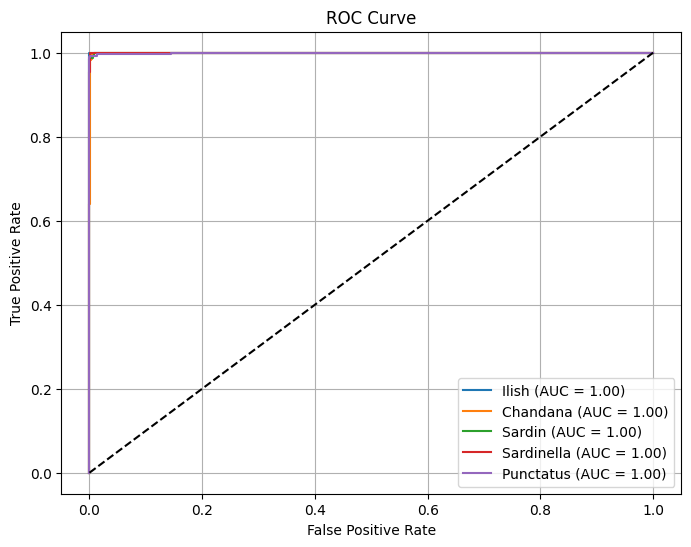

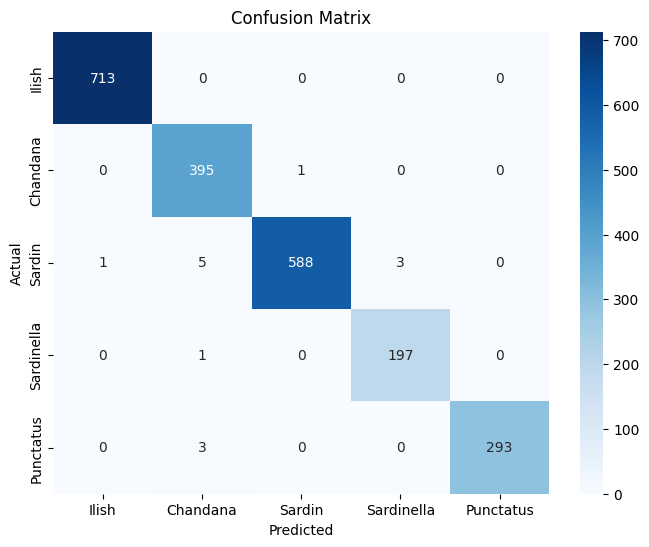

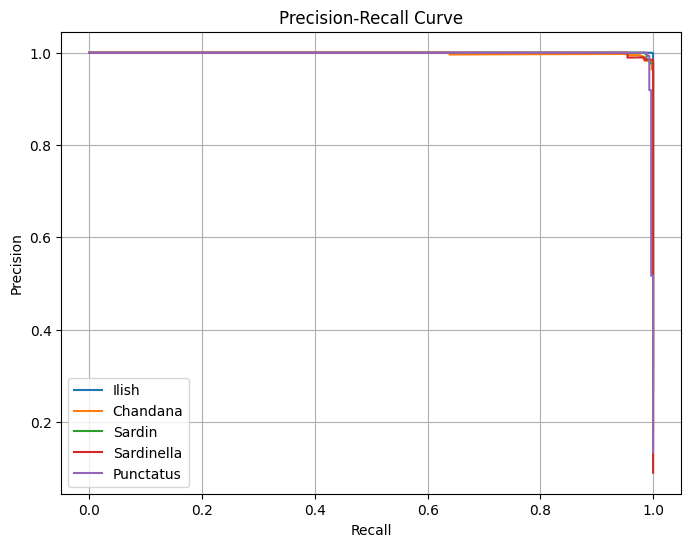

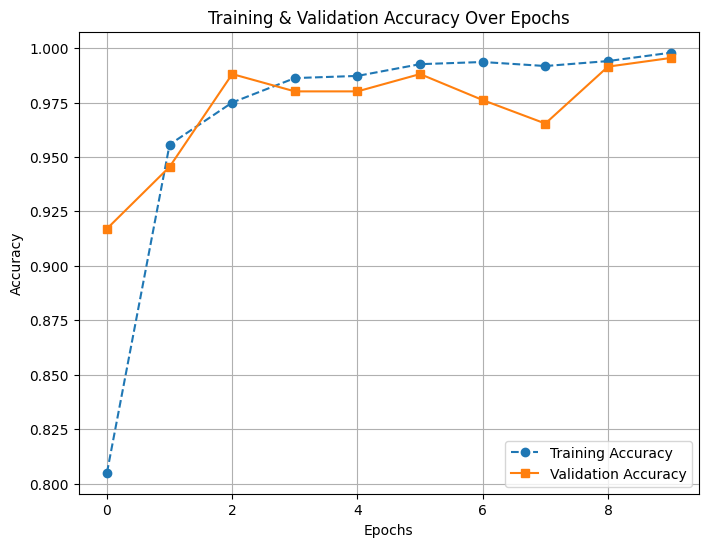

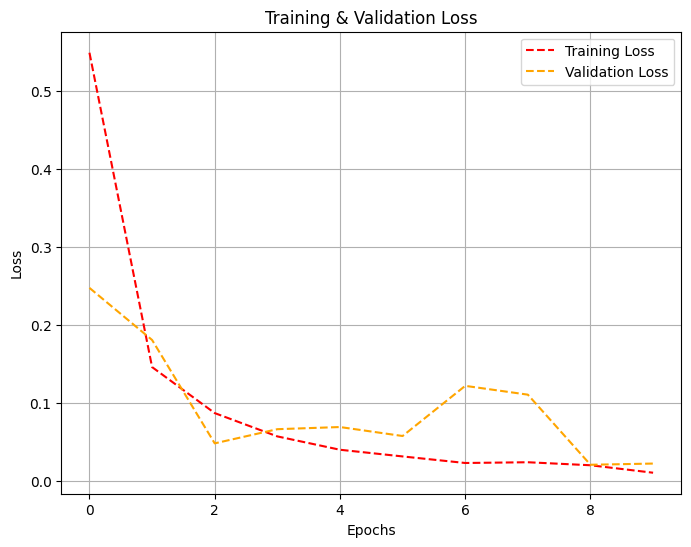

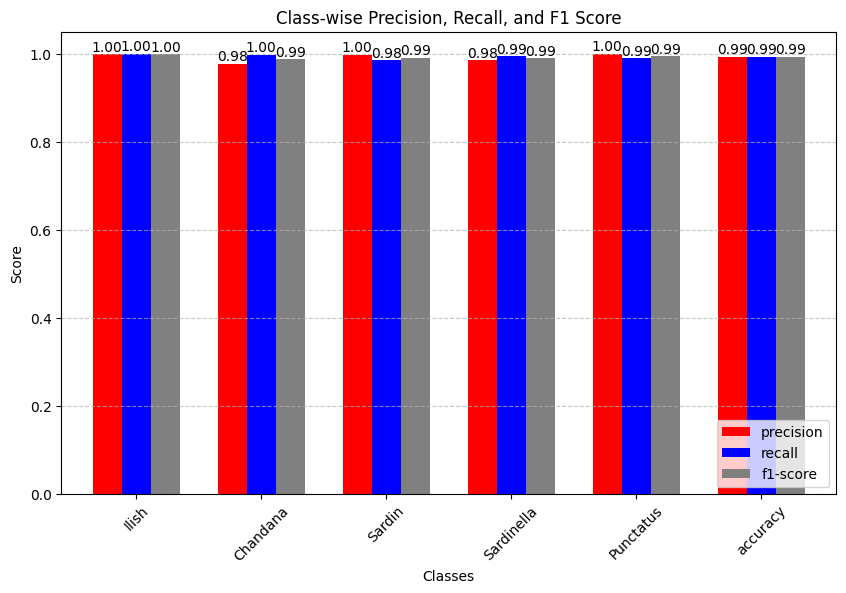


Final Model Performance:
Test Accuracy: 0.9936
F1 Score: 0.9936
Final predictions evaluated.


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0, VGG16, MobileNetV2, DenseNet121, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score, classification_report

# Define class labels
class_labels = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
callbacks = [checkpoint, earlystop, reduce_lr]

# Function to create a model with optimizations
def create_model(base_model_class, input_shape=(224, 224, 3), num_classes=5):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze last 10 layers for fine-tuning
    # for layer in base_model.layers[:-10]:
    #     layer.trainable = False
    # for layer in base_model.layers[-10:]:
    #     layer.trainable = True

    x = base_model.output
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create models for each architecture
models = {
    'ResNet50': create_model(ResNet50),
    'InceptionV3': create_model(InceptionV3)
    # 'EfficientNetB0': create_model(EfficientNetB0)
    # 'VGG16': create_model(VGG16),
    # 'MobileNetV2': create_model(MobileNetV2),
    # 'DenseNet121': create_model(DenseNet121),
    # 'Xception': create_model(Xception)
}

# Train all models and evaluate on validation set
history_dict = {}
model_accuracies = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = model.fit(X_train_scaled, Y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2, callbacks=callbacks)
    history_dict[model_name] = history
    val_accuracy = history.history['val_accuracy'][-1]
    model_accuracies[model_name] = val_accuracy
    print(f"{model_name} validation accuracy: {val_accuracy:.4f}")

# Calculate weights based on model accuracies
total_accuracy = sum(model_accuracies.values())
model_weights = {model_name: accuracy / total_accuracy for model_name, accuracy in model_accuracies.items()}

# Get predictions from all models (probabilities from softmax)
predictions_prob = {model_name: model.predict(X_test_scaled) for model_name, model in models.items()}

# Weighted average of predictions
weighted_preds_prob = np.zeros_like(next(iter(predictions_prob.values())))

for model_name, pred_prob in predictions_prob.items():
    weighted_preds_prob += model_weights[model_name] * pred_prob

# Get final predicted classes (argmax of weighted probabilities)
final_preds = np.argmax(weighted_preds_prob, axis=1)

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_test_scaled, Y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")



#Visualization & Analysis
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, accuracy_score, f1_score

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_test_scaled, Y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate Predictions
Y_test_pred_prob = model.predict(X_test_scaled)
Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)

# Define class labels
class_labels = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']

# Custom callback to track learning rate during training
class LRSchedulerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if 'lr' not in self.model.history.history:
            self.model.history.history['lr'] = []
        self.model.history.history['lr'].append(self.model.optimizer.lr.numpy())

# ROC Curve Plot
def plot_roc_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        y_true_binary = (Y_test == i).astype(int)
        y_score = Y_test_pred_prob[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(Y_test, Y_test_pred, class_labels):
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Precision-Recall Curve Plot
def plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        precision, recall, _ = precision_recall_curve((Y_test == i).astype(int), Y_test_pred_prob[:, i])
        plt.plot(recall, precision, label=f'{class_labels[i]}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Training & Validation Accuracy Plot
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='dashed', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    plt.title('Training & Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Training & Validation Loss Plot
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', linestyle='dashed', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed', color='orange')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Learning Rate Scheduler Plot
def plot_learning_rate(history):
    if 'lr' in history.history:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='purple')
        plt.title('Learning Rate Scheduler')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid()
        plt.show()

# Class-wise Precision, Recall, F1 Score Plot
def plot_classwise_metrics(Y_test, Y_test_pred, class_labels):
    report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)
    df_report = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    df_report = df_report[['precision', 'recall', 'f1-score']]
    colors = {'precision': 'red', 'recall': 'blue', 'f1-score': 'gray'}
    fig, ax = plt.subplots(figsize=(10, 6))
    df_report.plot(kind='bar', ax=ax, width=0.7, color=[colors[col] for col in df_report.columns])
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=10, color='black')
    plt.title('Class-wise Precision, Recall, and F1 Score')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='lower right', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Generate Plots
plot_roc_curve(Y_test, Y_test_pred_prob, class_labels)
plot_confusion_matrix(Y_test, Y_test_pred, class_labels)
plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels)
plot_accuracy(history)
plot_loss(history)
plot_learning_rate(history)
plot_classwise_metrics(Y_test, Y_test_pred, class_labels)

# Print Final Metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, Y_test_pred, average='weighted'):.4f}")
print("Final predictions evaluated.")


#2nd -Learnable Weighted Average

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold



#SMOTE
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter
# Assuming X and Y are your image data and labels
# X: image data (e.g., shape=(n_samples, height, width, channels)), Y: labels (0,1,2,3,4 for the 5 classes)

# Split original dataset into train & test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Flatten the image data (from 4D to 2D)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], -1)

# Apply SMOTE on training data only
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_reshaped, Y_train_reshaped)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(Y_train_resampled))

# Reshape X_train_resampled and X_test to have the shape (n_samples, 224, 224, 3)
X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)
X_test_resampled = X_test.reshape(-1, 224, 224, 3)
# Y_train_resampled = Y_train_resampled.reshape(-1, 224, 224, 3)

# Normalize pixel values to [0,1]
X_train_scaled = X_train_resampled / 255.0
X_test_scaled = X_test_resampled / 255.0

print(f"Shape of X_train_resampled: {X_train_resampled.shape}")  # Check the new shape
print(f"Shape of X_test_resampled: {X_test_resampled.shape}")  # Check the new shape




#Train
# Define class labels
class_labels = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)





# # Function to create a model with optimizations
# def create_model(base_model_class, input_shape=(224, 224, 3), num_classes=5):
#     base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)

#     x = base_model.output
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2, 2))(x)

#     x = GlobalAveragePooling2D()(x)
#     x = Dense(256)(x)
#     x = BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = Dropout(0.5)(x)
#     output = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=output)

#     model.compile(optimizer=RMSprop(learning_rate=1e-4),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model


# # Create models for each architecture
# models = {
#     'ResNet50': create_model(ResNet50),
#     'InceptionV3': create_model(InceptionV3)
#     # 'EfficientNetB0': create_model(EfficientNetB0)
#     # 'VGG16': create_model(VGG16),
#     # 'MobileNetV2': create_model(MobileNetV2),
#     # 'DenseNet121': create_model(DenseNet121),
#     # 'Xception': create_model(Xception)
# }





from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import Concatenate, Lambda, Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np

# Load pre-trained models (you can also load your custom models)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define an ensemble model
def create_ensemble_model(model1, model2, input_shape=(224, 224, 3), num_classes=5):
    # Renaming layers to avoid conflicts between models
    for layer in model1.layers:
        layer._name = f"resnet_{layer.name}"  # Rename layers for ResNet
    for layer in model2.layers:
        layer._name = f"inception_{layer.name}"  # Rename layers for Inception

    # Define the input layer that will be used for both models
    input_layer = Input(shape=input_shape)

    # Get the output from both models
    output1 = model1(input_layer)
    output2 = model2(input_layer)

    # Apply Global Average Pooling to reduce the dimensionality of the feature maps
    output1 = GlobalAveragePooling2D()(output1)
    output2 = GlobalAveragePooling2D()(output2)

    # Learnable weighted averaging
    alpha = tf.Variable(0.5, trainable=True, dtype=tf.float32, name="alpha")  # Learnable weight
    ensemble_output = Lambda(lambda x: alpha * x[0] + (1 - alpha) * x[1])([output1, output2])

    # Additional dense layers for improved performance
    x = Dense(128, activation='relu')(ensemble_output)
    x = Dropout(0.5)(x)
    final_output = Dense(num_classes, activation='softmax')(x)

    # Create ensemble model
    ensemble_model = Model(inputs=input_layer, outputs=final_output)

    # Compile the model
    ensemble_model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    return ensemble_model

# Create ensemble model using pre-defined ResNet and Inception models
ensemble_model = create_ensemble_model(resnet_model, inception_model)  # Replace with actual model variables

# Print model summary to verify
ensemble_model.summary()

# Implement Stratified K-Fold Cross-Validation
k_folds = 3  # Number of folds
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

history_dict = {}
model_accuracies = {}

# List of model names for reference
model_names = ['EnsembleModel']

# Create callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Function to create generators for image data
import tensorflow as tf

# Function to create dual generators for image data
def create_dual_generator(X, Y, batch_size=32):
    def generator():
        datagen = ImageDataGenerator()  # Normalize images
        flow = datagen.flow(X, Y, batch_size=batch_size)

        # Yield a tuple of (input for model1, input for model2), both being the same data for now
        while True:
            x, y = next(flow)  # Use next() instead of generator.next()
            yield ([x, x], y)  # Feed the same x for both models

    return generator



# Function to convert generator into tf.data.Dataset for correct output signature
def create_tf_dataset(generator_func):
    output_signature = (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input shape for model1 and model2
        tf.TensorSpec(shape=(None,), dtype=tf.int64)  # Label shape
    )
    return tf.data.Dataset.from_generator(generator_func, output_signature=output_signature)






# Iterate through K-Folds
for model_name in model_names:
    fold_no = 1
    history_dict[model_name] = []

    for train_index, val_index in skf.split(X_train_scaled, Y_train_resampled):
        print(f"\nTraining {model_name} - Fold {fold_no}/{k_folds}...")

        # Split dataset into training and validation sets
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        Y_train_fold, Y_val_fold = Y_train_resampled[train_index], Y_train_resampled[val_index]

        # Create generators for training and validation
        train_generator = create_dual_generator(X_train_fold, Y_train_fold)
        val_generator = create_dual_generator(X_val_fold, Y_val_fold)

        # Convert generators to tf.data.Dataset
        train_dataset = create_tf_dataset(train_generator)
        val_dataset = create_tf_dataset(val_generator)

        # Train ensemble model with the tf.data.Dataset
        history = ensemble_model.fit(
            train_dataset,
            epochs=5,
            verbose=1,
            validation_data=val_dataset,
            steps_per_epoch=len(X_train_fold) // 32,  # Number of steps per epoch (based on batch size)
            validation_steps=len(X_val_fold) // 32,  # Number of steps for validation
            callbacks=[checkpoint, earlystop, reduce_lr]
        )

        # Store history
        history_dict[model_name].append(history.history)

        # Compute validation accuracy
        val_accuracy = history.history['val_accuracy'][-1]
        print(f"Fold {fold_no} - {model_name} Validation Accuracy: {val_accuracy:.4f}")

        fold_no += 1

# After training, you can evaluate the model on test data or save it for future use
ensemble_model.save('final_ensemble_model.h5')










# Plot Accuracy & Loss Graph for Each Fold
def plot_kfold_results(history_dict, metric):
    plt.figure(figsize=(12, 6))
    for model_name, histories in history_dict.items():
        for i, history in enumerate(histories):
            plt.plot(history[metric], label=f"{model_name} - Fold {i+1}")

    plt.title(f"{metric.capitalize()} per Epoch (K-Fold)")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()
    plt.grid(True)


# Plot graphs
plot_kfold_results(history_dict, "accuracy")
plot_kfold_results(history_dict, "val_accuracy")
plot_kfold_results(history_dict, "loss")
plot_kfold_results(history_dict, "val_loss")



#Visualization & Analysis
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, accuracy_score, f1_score

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_test_scaled, Y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate Predictions
Y_test_pred_prob = model.predict(X_test_scaled)
Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)

# Define class labels
class_labels = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']

# Custom callback to track learning rate during training
class LRSchedulerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if 'lr' not in self.model.history.history:
            self.model.history.history['lr'] = []
        self.model.history.history['lr'].append(self.model.optimizer.lr.numpy())

# ROC Curve Plot
def plot_roc_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        y_true_binary = (Y_test == i).astype(int)
        y_score = Y_test_pred_prob[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(Y_test, Y_test_pred, class_labels):
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Precision-Recall Curve Plot
def plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        precision, recall, _ = precision_recall_curve((Y_test == i).astype(int), Y_test_pred_prob[:, i])
        plt.plot(recall, precision, label=f'{class_labels[i]}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Training & Validation Accuracy Plot
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='dashed', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    plt.title('Training & Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Training & Validation Loss Plot
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', linestyle='dashed', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed', color='orange')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Learning Rate Scheduler Plot
def plot_learning_rate(history):
    if 'lr' in history.history:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='purple')
        plt.title('Learning Rate Scheduler')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid()
        plt.show()

# Class-wise Precision, Recall, F1 Score Plot
def plot_classwise_metrics(Y_test, Y_test_pred, class_labels):
    report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)
    df_report = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    df_report = df_report[['precision', 'recall', 'f1-score']]
    colors = {'precision': 'red', 'recall': 'blue', 'f1-score': 'gray'}
    fig, ax = plt.subplots(figsize=(10, 6))
    df_report.plot(kind='bar', ax=ax, width=0.7, color=[colors[col] for col in df_report.columns])
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=10, color='black')
    plt.title('Class-wise Precision, Recall, and F1 Score')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='lower right', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Generate Plots
plot_roc_curve(Y_test, Y_test_pred_prob, class_labels)
plot_confusion_matrix(Y_test, Y_test_pred, class_labels)
plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels)
plot_accuracy(history)
plot_loss(history)
plot_learning_rate(history)
plot_classwise_metrics(Y_test, Y_test_pred, class_labels)

# Print Final Metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, Y_test_pred, average='weighted'):.4f}")
print("Final predictions evaluated.")

Class distribution after SMOTE: Counter({2: 1600, 0: 1600, 1: 1600, 4: 1600, 3: 1600})
Shape of X_train_resampled: (8000, 224, 224, 3)
Shape of X_test_resampled: (1500, 224, 224, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_v3 (Functional) │ (None, 5, 5, 2048)     │     21,802,784 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ inception_v3[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 2048)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │        262,272 │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 5)              │            645 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 45,653,413 (174.15 MB)

 Trainable params: 45,565,861 (173.82 MB)

 Non-trainable params: 87,552 (342.00 KB)


Training EnsembleModel - Fold 1/3...
Epoch 1/5


#3rd - Meta Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator






# Assuming X and Y are already loaded and preprocessed as numpy arrays
# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Normalize data
X_train_scaled = X_train
X_test_scaled = X_test

# Apply SMOTE to balance classes on the labels (not on flattened data)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled.reshape(X_train_scaled.shape[0], -1), Y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(Y_train_resampled))

# Reshape back to image format
X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)








# Define base model functions
def create_base_model(input_shape=(224, 224, 3), model_type='ResNet'):
    if model_type == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_type == 'Inception':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze the last 10 layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Add custom layers with Batch Normalization and Leaky ReLU
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First dense layer with Batch Normalization and Leaky ReLU
    x = Dense(256)(x)
    x = BatchNormalization()(x)  # Add BatchNormalization after the Dense layer
    x = LeakyReLU(alpha=0.1)(x)  # LeakyReLU with alpha = 0.1
    x = Dropout(0.5)(x)  # Dropout rate 0.5

    # Second dense layer with Batch Normalization and Leaky ReLU
    x = Dense(128)(x)
    x = BatchNormalization()(x)  # Add BatchNormalization after the Dense layer
    x = LeakyReLU(alpha=0.1)(x)  # LeakyReLU with alpha = 0.1
    x = Dropout(0.5)(x)  # Dropout rate 0.5

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model






# Create meta-model for stacking
def create_meta_model(input_shape=(256*2,), num_classes=5):
    input_layer = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input_layer)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model










# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Custom batch generator for data
def batch_generator(X, Y, batch_size=32):
    size = X.shape[0]
    while True:
        indices = np.random.permutation(size)
        for start in range(0, size, batch_size):
            end = min(start + batch_size, size)
            batch_idx = indices[start:end]
            X_batch, Y_batch = X[batch_idx], Y[batch_idx]

            # Ensure images are reshaped to (batch_size, 224, 224, 3)
            if len(X_batch.shape) == 3:  # If the shape is (batch_size, 224, 3)
                X_batch = X_batch.reshape(-1, 224, 224, 3)  # Reshape to include 3 channels

            # Apply augmentation using ImageDataGenerator
            # augmented_images = next(datagen.flow(X_batch, shuffle=False, batch_size=batch_size))[0]



            # yield augmented_images, Y_batch
            # Yield the batch without augmentation
            yield X_batch, Y_batch









# Train using K-Fold with stacking and data augmentation
def train_with_kfold(X_train_resampled, Y_train_resampled, X_test_scaled, Y_test, k=5, batch_size=32, epochs=10):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    histories = []

    # Storing all base model predictions
    base_model_predictions = []

    for train_idx, val_idx in skf.split(X_train_resampled, Y_train_resampled):
        print(f"Training fold {fold_no}/{k}...")

        # Split data into train and validation sets for each fold
        X_train_fold, X_val_fold = X_train_resampled[train_idx], X_train_resampled[val_idx]
        Y_train_fold, Y_val_fold = Y_train_resampled[train_idx], Y_train_resampled[val_idx]

        # Create base models
        resnet_model = create_base_model(input_shape=(224, 224, 3), model_type='ResNet')
        inception_model = create_base_model(input_shape=(224, 224, 3), model_type='Inception')

        # Create generators for training and validation data using the batch generator
        train_generator = batch_generator(X_train_fold, Y_train_fold, batch_size=batch_size)
        val_generator = batch_generator(X_val_fold, Y_val_fold, batch_size=batch_size)

        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            ModelCheckpoint(f'best_model_fold_{fold_no}.h5', save_best_only=True, monitor='val_loss', mode='min'),
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]










        # Train base models with custom batch generator
        resnet_model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1,
                         callbacks=callbacks, steps_per_epoch=len(X_train_fold)//batch_size,
                         validation_steps=len(X_val_fold)//batch_size)
        inception_model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1,
                             callbacks=callbacks, steps_per_epoch=len(X_train_fold)//batch_size,
                             validation_steps=len(X_val_fold)//batch_size)








        # Get predictions from base models
        resnet_preds = resnet_model.predict(X_val_fold)
        inception_preds = inception_model.predict(X_val_fold)

        # Stack predictions
        stacked_predictions = np.concatenate([resnet_preds, inception_preds], axis=1)
        base_model_predictions.append(stacked_predictions)

        fold_no += 1







    # Prepare stacked data for meta-model
    base_model_predictions = np.concatenate(base_model_predictions, axis=0)

    # Getting class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled)
    class_weight_dict = dict(zip(np.unique(Y_train_resampled), class_weights))

    # Train meta-model
    meta_model = create_meta_model(input_shape=(base_model_predictions.shape[1],))
    meta_model.fit(base_model_predictions, Y_train_resampled, epochs=epochs, batch_size=batch_size, verbose=1,
                   class_weight=class_weight_dict)

    return meta_model









# Train and visualize
meta_model = train_with_kfold(X_train_resampled, Y_train_resampled, X_test_scaled, Y_test, k=5)

# Print results
print("Training complete.")


Class distribution after SMOTE: Counter({3: 400, 1: 400, 2: 400, 4: 400, 0: 400})
Training fold 1/5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0564 - loss: 13.3134

50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.0600 - loss: 13.2455 - val_accuracy: 0.0000e+00 - val_loss: 14.3146 - learning_rate: 0.0010
Epoch 2/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3822 - loss: 8.2954

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.3818 - loss: 8.2817 - val_accuracy: 0.2969 - val_loss: 6.8647 - learning_rate: 0.0010
Epoch 3/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3364 - loss: 6.1350

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.3353 - loss: 6.1236 - val_accuracy: 0.3614 - val_loss: 4.8664 - learning_rate: 0.0010
Epoch 4/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2169 - loss: 5.6095

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2167 - loss: 5.6081 - val_accuracy: 0.4484 - val_loss: 4.4711 - learning_rate: 0.0010
Epoch 5/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2123 - loss: 5.4884

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2121 - loss: 5.4866 - val_accuracy: 0.5625 - val_loss: 4.4652 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2116 - loss: 5.2889 - val_accuracy: 0.6005 - val_loss: 4.6808 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2201 - loss: 5.5632 - val_accuracy: 0.6196 - val_loss: 4.7766 - learning_rate: 0.0010
Epoch 8/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2111 - loss: 5.3260
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2113 - loss: 5.3263 - val_accuracy: 0.6016 - val_loss: 4.8227 - learning_rate: 0.0010
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2257 - loss: 5.4650 - val_accuracy: 0.6033 - val_loss: 4.8069 - learning_rate: 5.0000e-04
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2148 - loss: 5.3958 - val_accuracy: 

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.0566 - loss: 13.0899 - val_accuracy: 0.0000e+00 - val_loss: 12.3649 - learning_rate: 0.0010
Epoch 2/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3368 - loss: 8.4407

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.3366 - loss: 8.4464 - val_accuracy: 0.0156 - val_loss: 11.1967 - learning_rate: 0.0010
Epoch 3/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3400 - loss: 8.3787

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.3396 - loss: 8.3677 - val_accuracy: 0.6196 - val_loss: 4.1551 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2977 - loss: 7.8352 - val_accuracy: 0.5272 - val_loss: 4.5663 - learning_rate: 0.0010
Epoch 5/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3683 - loss: 6.4290

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3676 - loss: 6.4075 - val_accuracy: 0.5516 - val_loss: 3.9047 - learning_rate: 0.0010
Epoch 6/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2674 - loss: 5.1049

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.2671 - loss: 5.1054 - val_accuracy: 0.5082 - val_loss: 3.3802 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2355 - loss: 5.2039 - val_accuracy: 0.5190 - val_loss: 4.4384 - learning_rate: 0.0010
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.2424 - loss: 5.2248 - val_accuracy: 0.5781 - val_loss: 4.7606 - learning_rate: 0.0010
Epoch 9/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1965 - loss: 5.3080
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1965 - loss: 5.3047 - val_accuracy: 0.5598 - val_loss: 4.7776 - learning_rate: 0.0010
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1826 - loss: 5.2153 - val_accuracy: 0.5897 - val_loss: 4.7941 - learning_rate: 5.0000e-04
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 206ms/step - accuracy: 0.0208 - loss: 14.5445 - val_accurac

50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 0.0843 - loss: 12.6596 - val_accuracy: 0.1328 - val_loss: 14.5231 - learning_rate: 0.0010
Epoch 2/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2844 - loss: 7.9556

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.2826 - loss: 7.9238 - val_accuracy: 0.3568 - val_loss: 3.8244 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.1879 - loss: 5.8729 - val_accuracy: 0.4755 - val_loss: 3.9428 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.1944 - loss: 5.6798 - val_accuracy: 0.1766 - val_loss: 5.4812 - learning_rate: 0.0010
Epoch 5/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2056 - loss: 5.6804
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2052 - loss: 5.6772 - val_accuracy: 0.3071 - val_loss: 4.8259 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1946 - loss: 5.5759 - val_accuracy: 0.5679 - val_loss: 4.8798 - learning_rate: 5.0000e-04
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.2017 - loss: 5.4891 - val_accuracy: 0

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.0808 - loss: 13.2898 - val_accuracy: 0.0000e+00 - val_loss: 13.8618 - learning_rate: 0.0010
Epoch 2/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3176 - loss: 8.6006

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3176 - loss: 8.5678 - val_accuracy: 0.2708 - val_loss: 4.8094 - learning_rate: 0.0010
Epoch 3/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2583 - loss: 5.9166

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.2577 - loss: 5.9126 - val_accuracy: 0.4266 - val_loss: 4.2663 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2138 - loss: 5.6552 - val_accuracy: 0.5190 - val_loss: 4.3692 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2026 - loss: 5.6053 - val_accuracy: 0.6359 - val_loss: 4.7275 - learning_rate: 0.0010
Epoch 6/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1836 - loss: 5.4604
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1842 - loss: 5.4607 - val_accuracy: 0.5788 - val_loss: 4.8388 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2141 - loss: 5.4174 - val_accuracy: 0.6332 - val_loss: 4.8494 - learning_rate: 5.0000e-04
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.1796 - loss: 5.4265 - val_accuracy: 

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.0548 - loss: 13.5177 - val_accuracy: 0.0000e+00 - val_loss: 20.6584 - learning_rate: 0.0010
Epoch 2/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3099 - loss: 9.6791

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.3103 - loss: 9.6623 - val_accuracy: 0.0938 - val_loss: 9.5200 - learning_rate: 0.0010
Epoch 3/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3736 - loss: 7.7497

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.3747 - loss: 7.7261 - val_accuracy: 0.3723 - val_loss: 3.7784 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3808 - loss: 6.8320 - val_accuracy: 0.2092 - val_loss: 4.8513 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3046 - loss: 6.0079 - val_accuracy: 0.2418 - val_loss: 4.0118 - learning_rate: 0.0010
Epoch 6/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2214 - loss: 5.7343
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.2216 - loss: 5.7358 - val_accuracy: 0.4701 - val_loss: 4.4353 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2387 - loss: 5.5766 - val_accuracy: 0.5489 - val_loss: 4.1169 - learning_rate: 5.0000e-04
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2681 - loss: 5.5949 - val_accuracy: 

#4th - Adaptive Weighted Ensemble

Class distribution after SMOTE: Counter({3: 400, 1: 400, 2: 400, 4: 400, 0: 400})
Training Fold 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.5596 - loss: 1.1453

41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 615ms/step - accuracy: 0.5624 - loss: 1.1382 - val_accuracy: 0.7312 - val_loss: 2.9683 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8388 - loss: 0.4427

41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 486ms/step - accuracy: 0.8394 - loss: 0.4415 - val_accuracy: 0.8234 - val_loss: 1.4814 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9048 - loss: 0.3223

41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 474ms/step - accuracy: 0.9046 - loss: 0.3222 - val_accuracy: 0.8172 - val_loss: 1.2226 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9184 - loss: 0.2551

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 530ms/step - accuracy: 0.9186 - loss: 0.2543 - val_accuracy: 0.8992 - val_loss: 0.3343 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 345ms/step - accuracy: 0.9285 - loss: 0.2027 - val_accuracy: 0.8703 - val_loss: 0.5366 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9438 - loss: 0.2056

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.9436 - loss: 0.2055 - val_accuracy: 0.9071 - val_loss: 0.2664 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 297ms/step - accuracy: 0.9439 - loss: 0.1758 - val_accuracy: 0.9197 - val_loss: 0.3006 - learning_rate: 0.0010
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9463 - loss: 0.1782

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 360ms/step - accuracy: 0.9462 - loss: 0.1783 - val_accuracy: 0.9433 - val_loss: 0.2010 - learning_rate: 0.0010
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9489 - loss: 0.1785

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step - accuracy: 0.9489 - loss: 0.1785 - val_accuracy: 0.9638 - val_loss: 0.1650 - learning_rate: 0.0010
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - accuracy: 0.9790 - loss: 0.0932 - val_accuracy: 0.9433 - val_loss: 0.2182 - learning_rate: 0.0010
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4707 - loss: 1.3847 - val_accuracy: 0.8929 - val_loss: 0.3393 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 426ms/step - accuracy: 0.8595 - loss: 0.4289 - val_accuracy: 0.8992 - val_loss: 0.2837 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 410ms/step - accuracy: 0.8865 - loss: 0.3277 - val_accuracy: 0.9449 - val_loss: 0.1666 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9189 - loss: 0.2376

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 363ms/step - accuracy: 0.9187 - loss: 0.2377 - val_accuracy: 0.9496 - val_loss: 0.1387 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9453 - loss: 0.1909

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 322ms/step - accuracy: 0.9452 - loss: 0.1910 - val_accuracy: 0.9654 - val_loss: 0.1128 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9376 - loss: 0.1839

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 322ms/step - accuracy: 0.9376 - loss: 0.1836 - val_accuracy: 0.9669 - val_loss: 0.0915 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9568 - loss: 0.1474

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 320ms/step - accuracy: 0.9568 - loss: 0.1475 - val_accuracy: 0.9685 - val_loss: 0.0882 - learning_rate: 0.0010
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step - accuracy: 0.9627 - loss: 0.1242 - val_accuracy: 0.9575 - val_loss: 0.1311 - learning_rate: 0.0010
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 323ms/step - accuracy: 0.9435 - loss: 0.1517 - val_accuracy: 0.9748 - val_loss: 0.0985 - learning_rate: 0.0010
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9682 - loss: 0.1147
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 322ms/step - accuracy: 0.9682 - loss: 0.1148 - val_accuracy: 0.9654 - val_loss: 0.1072 - learning_rate: 0.0010
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 535ms/step
Training Fold 2/3
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5291 - loss: 1.2653

41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 595ms/step - accuracy: 0.5323 - loss: 1.2571 - val_accuracy: 0.5500 - val_loss: 9.0957 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8548 - loss: 0.4430

41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 479ms/step - accuracy: 0.8552 - loss: 0.4423 - val_accuracy: 0.7453 - val_loss: 1.8654 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9012 - loss: 0.3123

41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 462ms/step - accuracy: 0.9013 - loss: 0.3121 - val_accuracy: 0.7781 - val_loss: 1.2450 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9202 - loss: 0.2242

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - accuracy: 0.9201 - loss: 0.2249 - val_accuracy: 0.8882 - val_loss: 0.4021 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9263 - loss: 0.2221

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 375ms/step - accuracy: 0.9265 - loss: 0.2216 - val_accuracy: 0.9203 - val_loss: 0.2576 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9525 - loss: 0.1656

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 324ms/step - accuracy: 0.9524 - loss: 0.1659 - val_accuracy: 0.9055 - val_loss: 0.2386 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9429 - loss: 0.1834

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 328ms/step - accuracy: 0.9431 - loss: 0.1829 - val_accuracy: 0.9260 - val_loss: 0.2145 - learning_rate: 0.0010
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.9385 - loss: 0.1820 - val_accuracy: 0.9008 - val_loss: 0.3148 - learning_rate: 0.0010
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9666 - loss: 0.1264

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 358ms/step - accuracy: 0.9664 - loss: 0.1265 - val_accuracy: 0.9496 - val_loss: 0.1896 - learning_rate: 0.0010
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - accuracy: 0.9657 - loss: 0.1168 - val_accuracy: 0.8835 - val_loss: 0.4234 - learning_rate: 0.0010
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 914ms/step - accuracy: 0.5167 - loss: 1.3390 - val_accuracy: 0.8441 - val_loss: 0.4109 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 418ms/step - accuracy: 0.8386 - loss: 0.4631 - val_accuracy: 0.8866 - val_loss: 0.2920 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 391ms/step - accuracy: 0.8922 - loss: 0.3104 - val_accuracy: 0.9197 - val_loss: 0.2271 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step - accuracy: 0.9063 - loss: 0.2626 - val_accuracy: 0.9165 - val_loss: 0.2132 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9256 - loss: 0.2129

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 335ms/step - accuracy: 0.9258 - loss: 0.2127 - val_accuracy: 0.9622 - val_loss: 0.1173 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step - accuracy: 0.9463 - loss: 0.1846 - val_accuracy: 0.9465 - val_loss: 0.1289 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step - accuracy: 0.9518 - loss: 0.1493 - val_accuracy: 0.9512 - val_loss: 0.1467 - learning_rate: 0.0010
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9452 - loss: 0.1474

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 339ms/step - accuracy: 0.9454 - loss: 0.1470 - val_accuracy: 0.9606 - val_loss: 0.1105 - learning_rate: 0.0010
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - accuracy: 0.9526 - loss: 0.1412 - val_accuracy: 0.9559 - val_loss: 0.1369 - learning_rate: 0.0010
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 316ms/step - accuracy: 0.9675 - loss: 0.1107 - val_accuracy: 0.9528 - val_loss: 0.1415 - learning_rate: 0.0010
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 419ms/step
Training Fold 3/3
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5353 - loss: 1.2722

41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 597ms/step - accuracy: 0.5386 - loss: 1.2631 - val_accuracy: 0.4125 - val_loss: 13.5787 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8660 - loss: 0.4179

41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 482ms/step - accuracy: 0.8663 - loss: 0.4172 - val_accuracy: 0.8766 - val_loss: 0.7870 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 418ms/step - accuracy: 0.9040 - loss: 0.3188 - val_accuracy: 0.8250 - val_loss: 1.1312 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9266 - loss: 0.2270

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 525ms/step - accuracy: 0.9263 - loss: 0.2278 - val_accuracy: 0.8517 - val_loss: 0.6150 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9319 - loss: 0.2152

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 382ms/step - accuracy: 0.9319 - loss: 0.2153 - val_accuracy: 0.9516 - val_loss: 0.1483 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 289ms/step - accuracy: 0.9473 - loss: 0.1720 - val_accuracy: 0.9511 - val_loss: 0.1765 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 326ms/step - accuracy: 0.9392 - loss: 0.2047 - val_accuracy: 0.8880 - val_loss: 0.4762 - learning_rate: 0.0010
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9518 - loss: 0.1451
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step - accuracy: 0.9517 - loss: 0.1454 - val_accuracy: 0.8707 - val_loss: 0.4497 - learning_rate: 0.0010
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 320ms/step - accuracy: 0.9385 - loss: 0.1742 - val_accuracy: 0.9558 - val_loss: 0.1486 - learning_rate: 5.0000e-04
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9709 - loss: 0.0992

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 361ms/step - accuracy: 0.9707 - loss: 0.0999 - val_accuracy: 0.9606 - val_loss: 0.1312 - learning_rate: 5.0000e-04
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.4870 - loss: 1.3626 - val_accuracy: 0.8044 - val_loss: 0.4659 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 419ms/step - accuracy: 0.8289 - loss: 0.4731 - val_accuracy: 0.9085 - val_loss: 0.2687 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 393ms/step - accuracy: 0.8910 - loss: 0.3306 - val_accuracy: 0.9464 - val_loss: 0.1716 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step - accuracy: 0.9324 - loss: 0.2272 - val_accuracy: 0.9495 - val_loss: 0.1432 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 318ms/step - accuracy: 0.9241 - loss: 0.2169 - val_accuracy: 0.9479 - val_loss: 0.1315 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - accuracy: 0.9398 - loss: 0.1988 - val

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 336ms/step - accuracy: 0.9579 - loss: 0.1584 - val_accuracy: 0.9669 - val_loss: 0.0879 - learning_rate: 0.0010
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 297ms/step - accuracy: 0.9506 - loss: 0.1545 - val_accuracy: 0.9700 - val_loss: 0.1023 - learning_rate: 0.0010
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - accuracy: 0.9474 - loss: 0.1593 - val_accuracy: 0.9637 - val_loss: 0.1173 - learning_rate: 0.0010
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9574 - loss: 0.1392
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step - accuracy: 0.9575 - loss: 0.1390 - val_accuracy: 0.9574 - val_loss: 0.1166 - learning_rate: 0.0010
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 408ms/step
Final Ensemble Model Accuracy: 95.80%
Training Complete. Adaptive Weighted Ensemble Model is ready!


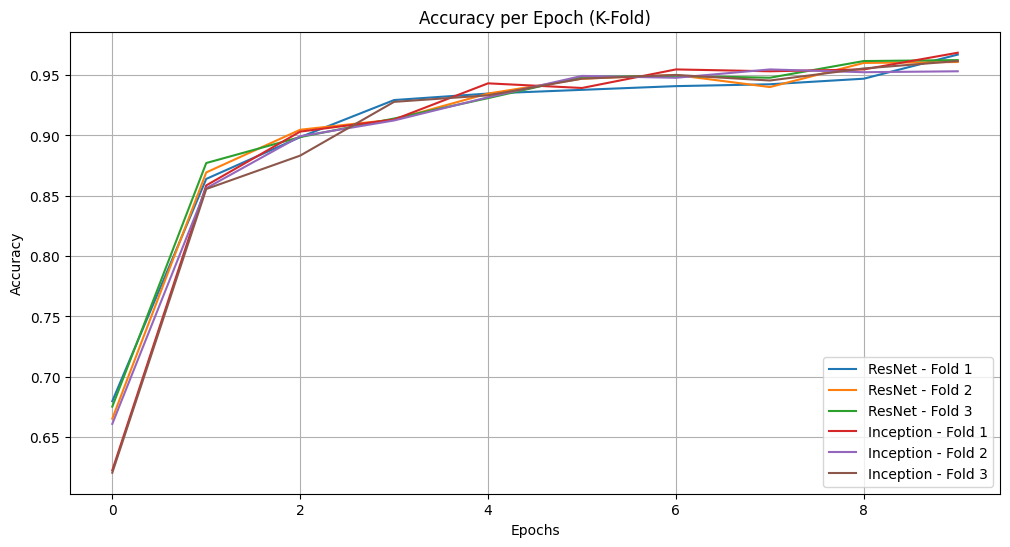

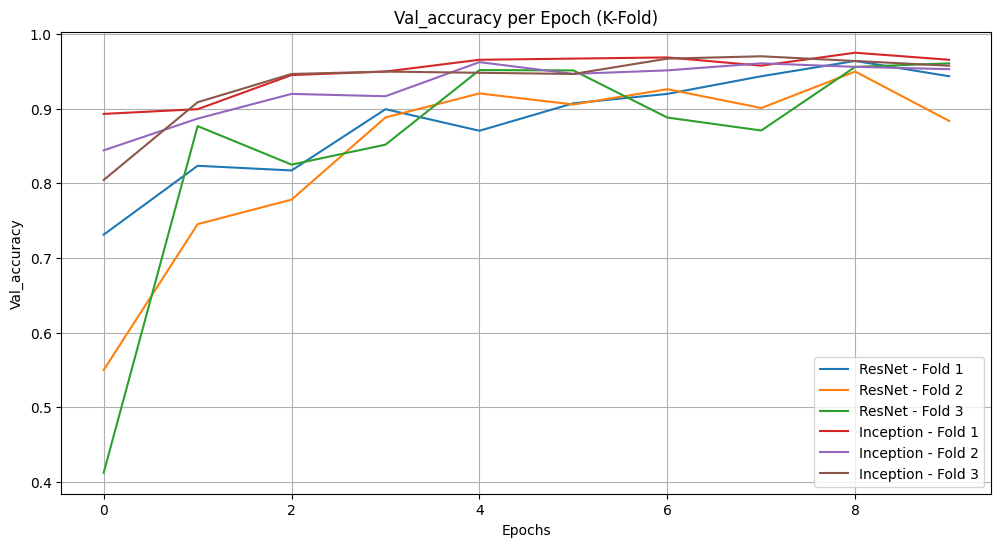

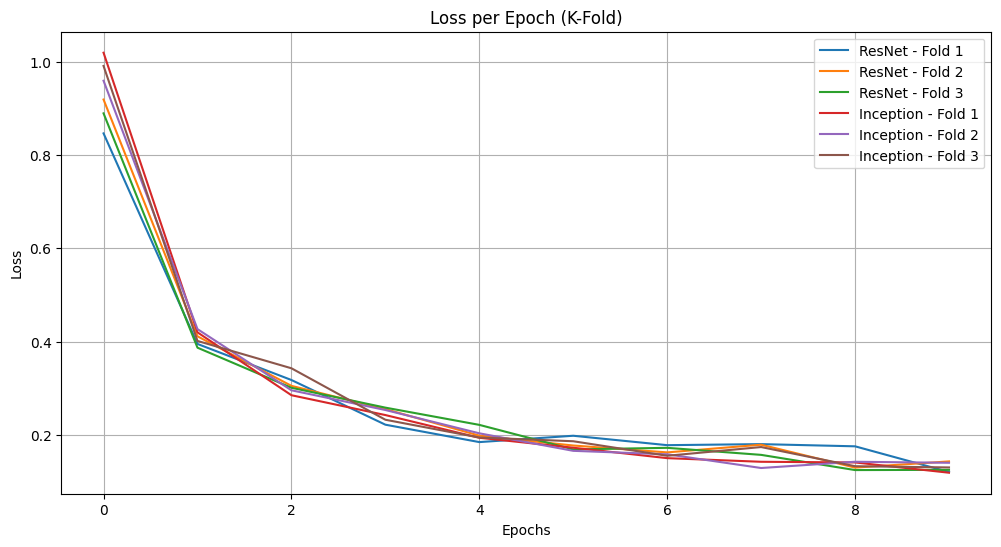

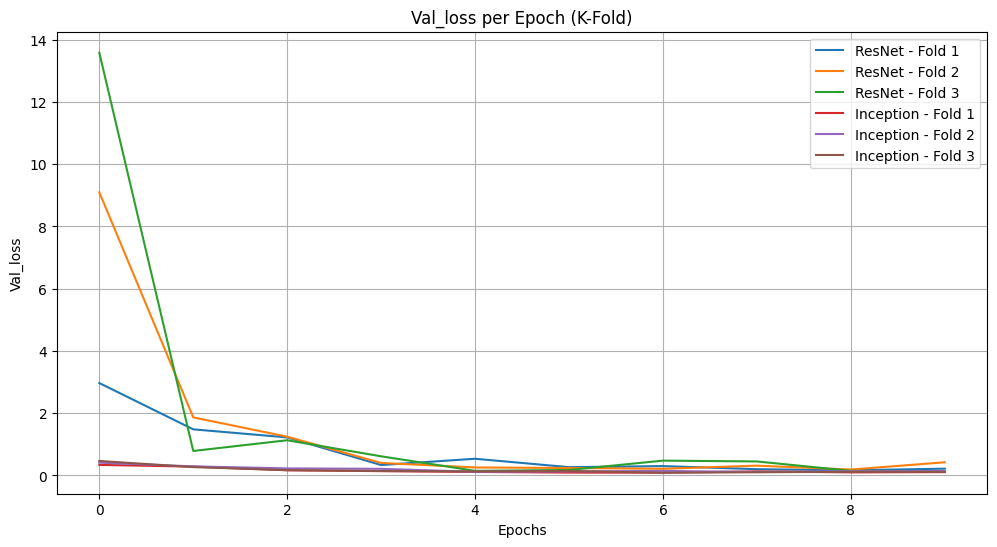

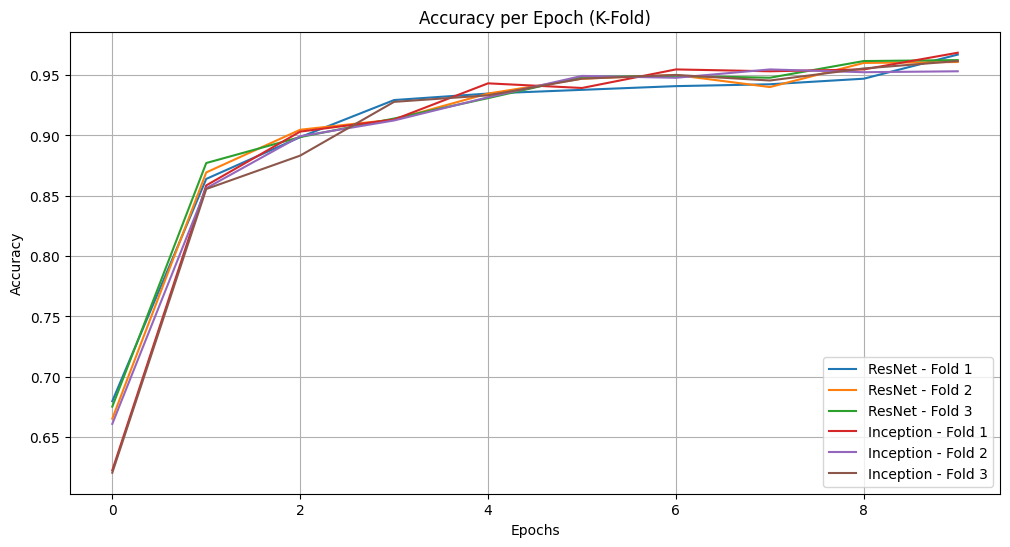

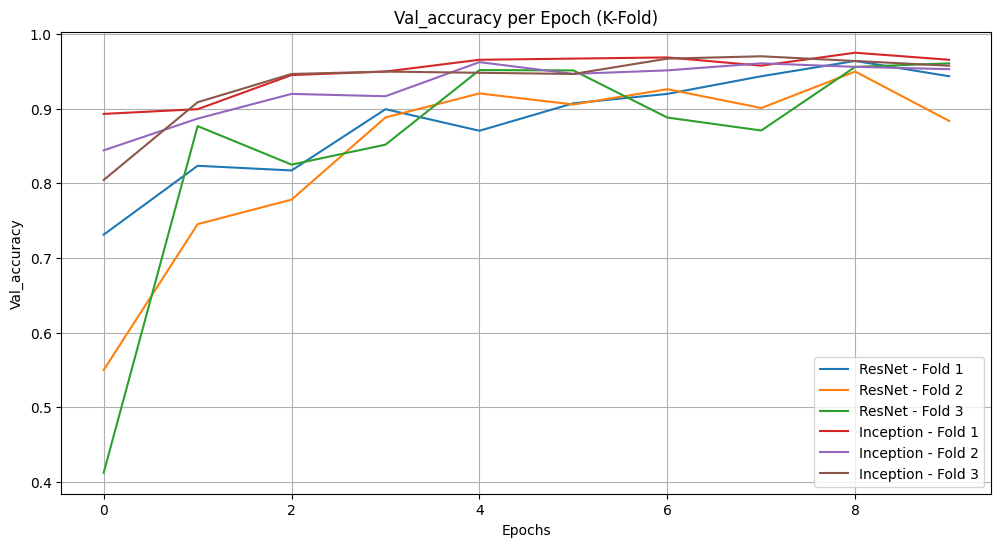

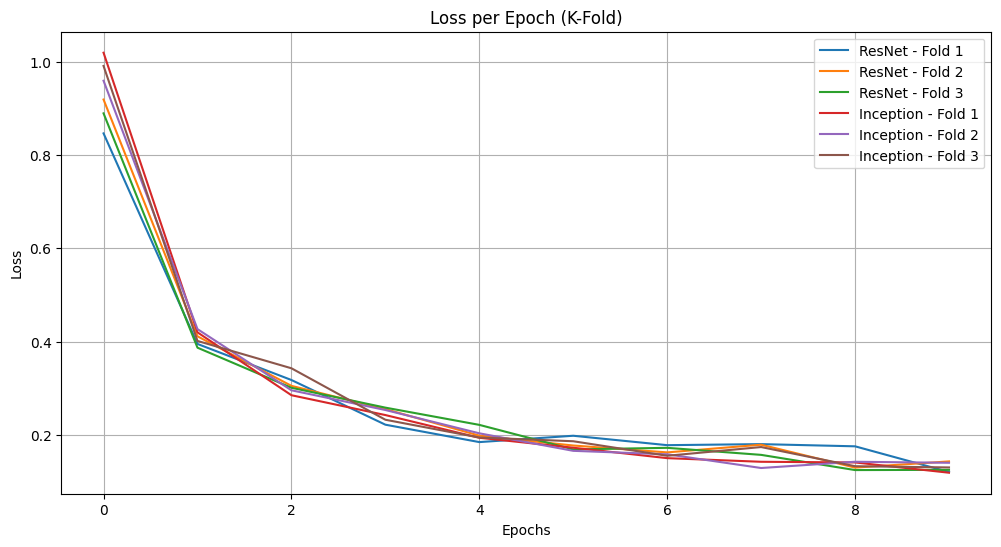

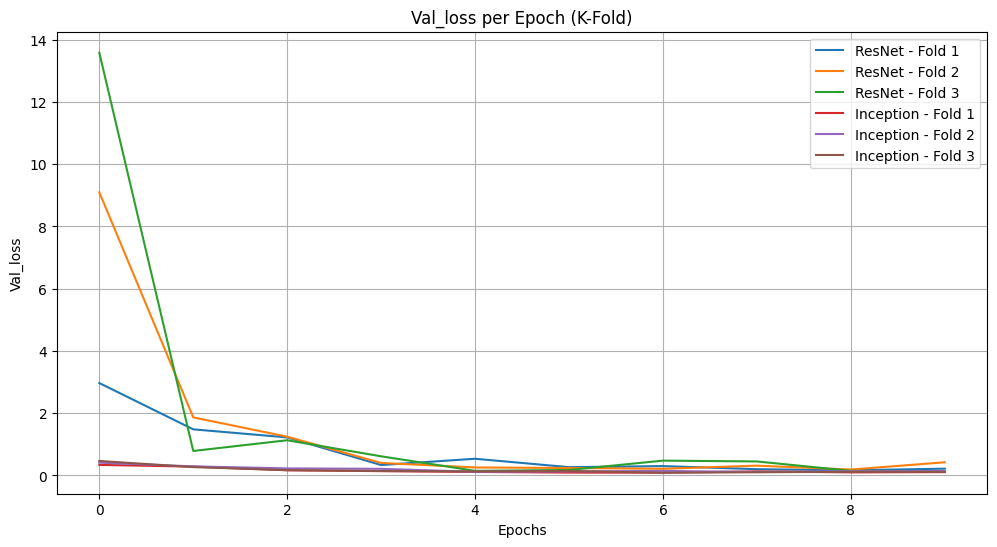

Error: Model outputs single class labels, please use predict_proba() to get probabilities.


<Figure size 800x600 with 0 Axes>

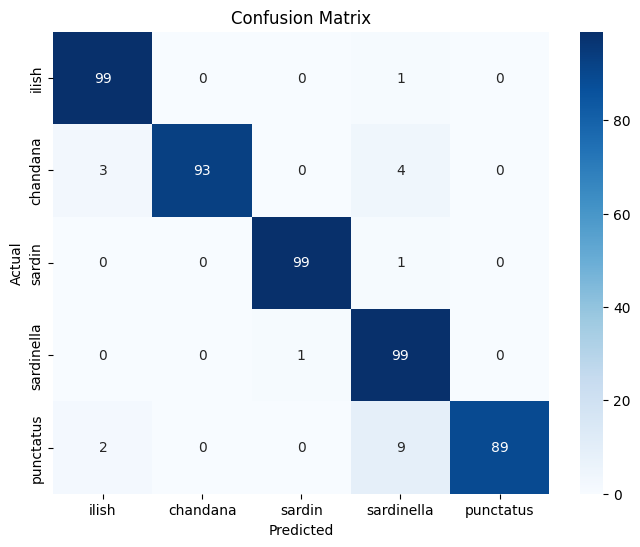

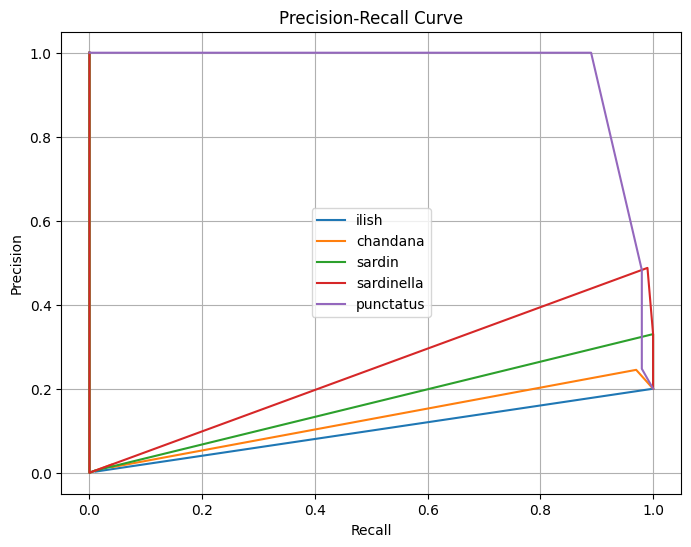

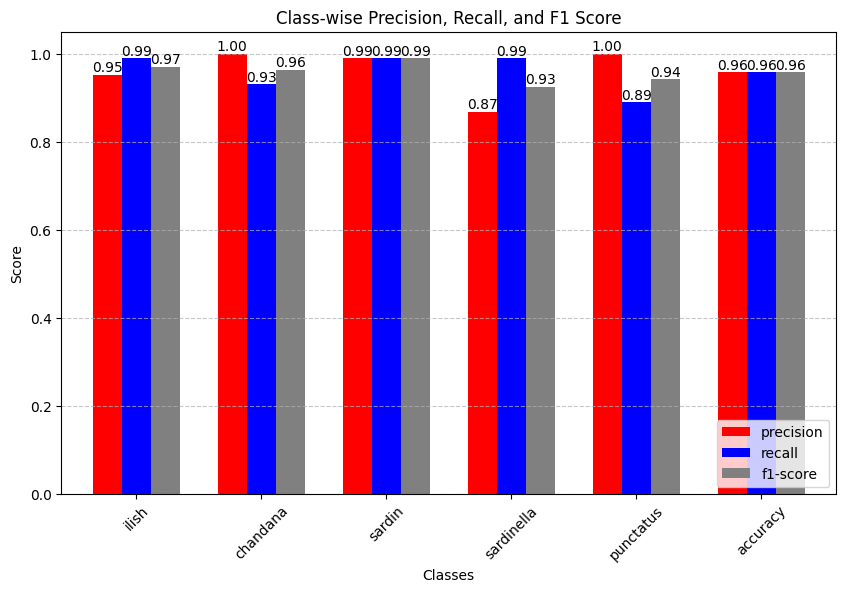


Final Model Performance:
Test Accuracy: 0.9580
F1 Score: 0.9583


In [ ]:
# Install imbalanced-learn if not installed
!pip install imbalanced-learn

# 📌 Data Processing and Model Evaluation
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# 📌 TensorFlow/Keras Components
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📌 Scikit-learn for Data Splitting and Evaluation
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score, classification_report

# 📌 Handling Imbalanced Data
from imblearn.over_sampling import SMOTE




# Assuming X and Y are already loaded and preprocessed as numpy arrays
# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Normalize data
X_train_scaled = X_train
X_test_scaled = X_test

# Apply SMOTE to balance classes on the labels (not on flattened data)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled.reshape(X_train_scaled.shape[0], -1), Y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(Y_train_resampled))

# Reshape back to image format
X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)






# Parameters
input_shape = (224, 224, 3)
num_classes = 5
batch_size = 32
epochs = 5
k_folds = 3

# Image Augmentation
datagen = ImageDataGenerator(
    # rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Custom Batch Generator
def batch_generator(X, Y, batch_size=32):
    size = X.shape[0]
    while True:
        indices = np.random.permutation(size)
        for start in range(0, size, batch_size):
            end = min(start + batch_size, size)
            batch_idx = indices[start:end]
            X_batch, Y_batch = X[batch_idx], Y[batch_idx]

            # Apply augmentation
            augmented_images = next(datagen.flow(X_batch, shuffle=False, batch_size=batch_size))
            yield augmented_images, to_categorical(Y_batch, num_classes)

# Create Base Model (ResNet/Inception)
def create_base_model(input_shape=(224, 224, 3), model_type='ResNet'):
    if model_type == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_type == 'Inception':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze top 10 layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)

    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# K-Fold Training with Adaptive Weighted Ensemble
# Modify train_with_kfold function
def train_with_kfold(X_train, Y_train, X_test, Y_test, k=5, batch_size=32, epochs=10):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    histories = {'ResNet': [], 'Inception': []}  # Store histories for each model
    ensemble_predictions = np.zeros((X_test.shape[0], num_classes))

    for fold_no, (train_idx, val_idx) in enumerate(skf.split(X_train, Y_train), 1):
        print(f"Training Fold {fold_no}/{k}")

        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

        resnet_model = create_base_model(model_type='ResNet')
        inception_model = create_base_model(model_type='Inception')

        train_generator = batch_generator(X_train_fold, Y_train_fold, batch_size)
        val_generator = batch_generator(X_val_fold, Y_val_fold, batch_size)

        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            ModelCheckpoint(f'best_model_resnet_fold_{fold_no}.h5', save_best_only=True, monitor='val_loss', mode='min'),
            ModelCheckpoint(f'best_model_inception_fold_{fold_no}.h5', save_best_only=True, monitor='val_loss', mode='min'),
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]

        history_resnet = resnet_model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1,
                                          callbacks=callbacks, steps_per_epoch=len(X_train_fold)//batch_size,
                                          validation_steps=len(X_val_fold)//batch_size)

        history_inception = inception_model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1,
                                                callbacks=callbacks, steps_per_epoch=len(X_train_fold)//batch_size,
                                                validation_steps=len(X_val_fold)//batch_size)

        histories['ResNet'].append(history_resnet)
        histories['Inception'].append(history_inception)

        resnet_preds = resnet_model.predict(X_test)
        inception_preds = inception_model.predict(X_test)

        resnet_conf = np.max(resnet_preds, axis=1)
        inception_conf = np.max(inception_preds, axis=1)

        resnet_weight = resnet_conf / (resnet_conf + inception_conf)
        inception_weight = inception_conf / (resnet_conf + inception_conf)

        final_preds = (resnet_weight[:, np.newaxis] * resnet_preds) + (inception_weight[:, np.newaxis] * inception_preds)

        ensemble_predictions += final_preds

    ensemble_predictions /= k
    final_classes = np.argmax(ensemble_predictions, axis=1)
    accuracy = np.mean(final_classes == Y_test)
    print(f"Final Ensemble Model Accuracy: {accuracy * 100:.2f}%")

    return final_classes, histories  # Return history for visualization

# Train and Evaluate
final_predictions, history_dict = train_with_kfold(X_train_resampled, Y_train_resampled, X_test_scaled, Y_test, k=k_folds)
print("Training Complete. Adaptive Weighted Ensemble Model is ready!")





class_labels = ['ilish', 'chandana', 'sardin', 'sardinella', 'punctatus']

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, accuracy_score, f1_score

# Function to plot Accuracy & Loss per Fold
def plot_kfold_results(history_dict, metric):
    plt.figure(figsize=(12, 6))
    for model_name, histories in history_dict.items():
        for i, history in enumerate(histories):
            # Access the history dictionary to get the metric
            if metric in history.history:
                plt.plot(history.history[metric], label=f"{model_name} - Fold {i+1}")

    plt.title(f"{metric.capitalize()} per Epoch (K-Fold)")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot Accuracy & Loss per Fold
plot_kfold_results(history_dict, "accuracy")
plot_kfold_results(history_dict, "val_accuracy")
plot_kfold_results(history_dict, "loss")
plot_kfold_results(history_dict, "val_loss")


# Plot Accuracy & Loss per Fold
plot_kfold_results(history_dict, "accuracy")
plot_kfold_results(history_dict, "val_accuracy")
plot_kfold_results(history_dict, "loss")
plot_kfold_results(history_dict, "val_loss")

# ROC Curve Plot
def plot_roc_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    if Y_test_pred_prob.ndim == 1:  # If the predictions are single class labels
        print("Error: Model outputs single class labels, please use predict_proba() to get probabilities.")
        return
    for i in range(len(class_labels)):
        y_true_binary = (Y_test == i).astype(int)
        y_score = Y_test_pred_prob[:, i]  # Accessing the predicted probabilities
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()


# Confusion Matrix Plot
def plot_confusion_matrix(Y_test, Y_test_pred, class_labels):
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Precision-Recall Curve Plot
def plot_precision_recall_curve(Y_test, Y_test_pred, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        y_true_binary = (Y_test == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_true_binary, Y_test_pred)  # Use Y_test_pred directly
        plt.plot(recall, precision, label=f'{class_labels[i]}')

    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()


# Class-wise Precision, Recall, F1 Score Plot
def plot_classwise_metrics(Y_test, Y_test_pred, class_labels):
    report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report = df_report[['precision', 'recall', 'f1-score']].drop(['macro avg', 'weighted avg'], errors='ignore')

    colors = {'precision': 'red', 'recall': 'blue', 'f1-score': 'gray'}
    fig, ax = plt.subplots(figsize=(10, 6))
    df_report.plot(kind='bar', ax=ax, width=0.7, color=[colors[col] for col in df_report.columns])

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=10, color='black')

    plt.title('Class-wise Precision, Recall, and F1 Score')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='lower right', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# Generate Ensemble-Based Plots
plot_roc_curve(Y_test, final_predictions, class_labels)
plot_confusion_matrix(Y_test, final_predictions, class_labels)
plot_precision_recall_curve(Y_test, final_predictions, class_labels)
plot_classwise_metrics(Y_test, final_predictions, class_labels)



# Print Final Metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, final_predictions):.4f}")
print(f"F1 Score: {f1_score(Y_test, final_predictions, average='weighted'):.4f}")

#SMOTE (Synthetic Minority Over-sampling Technique)

Synthetic Sample=Original Sample+λ×(Neighbor Sample−Original Sample)
1.Original Sample is the current sample from the minority class.
2.Neighbor Sample is a randomly chosen sample from the k-nearest neighbors.
3.λ is a random value between 0 and 1, which controls the degree of interpolation.


Class distribution after SMOTE: Counter({3: 400, 1: 400, 2: 400, 4: 400, 0: 400})
Shape of X_train_resampled: (2000, 224, 224, 3)
Shape of X_test_scaled: (500, 224, 224, 3)
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.5625 - loss: 1.1945
Epoch 1: val_loss improved from inf to 1.74173, saving model to model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 121s 745ms/step - accuracy: 0.5655 - loss: 1.1868 - val_accuracy: 0.6300 - val_loss: 1.7417 - learning_rate: 1.0000e-04
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9490 - loss: 0.1592
Epoch 2: val_loss improved from 1.74173 to 0.21080, saving model to model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.9490 - loss: 0.1591 - val_accuracy: 0.9400 - val_loss: 0.2108 - learning_rate: 1.0000e-04
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9829 - loss: 0.0802
Epoch 3: val_loss improved from 0.21080 to 0.13079, saving model to model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/ste

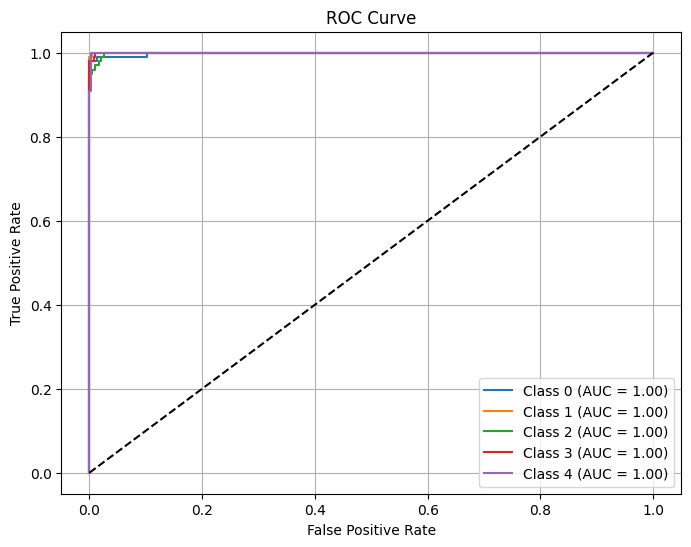

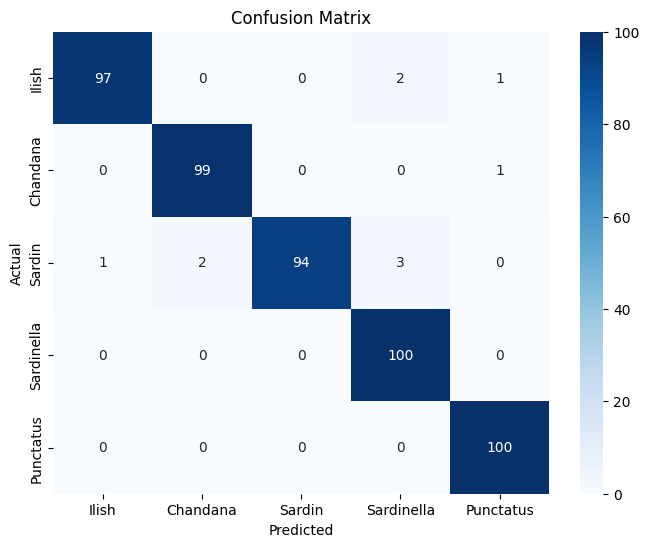

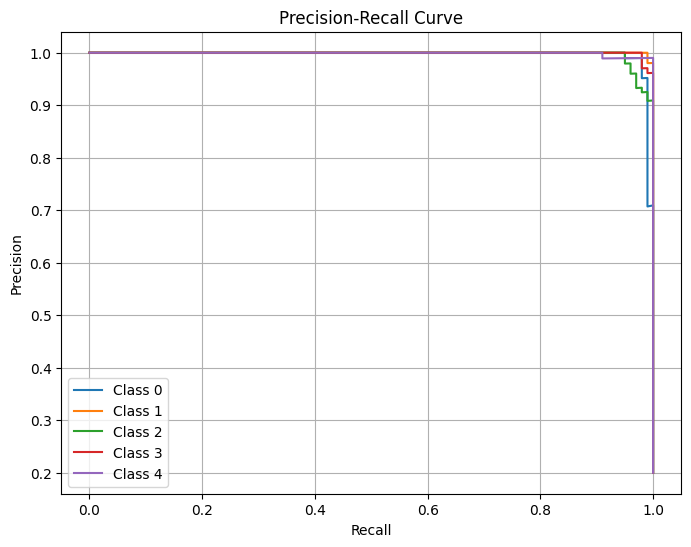

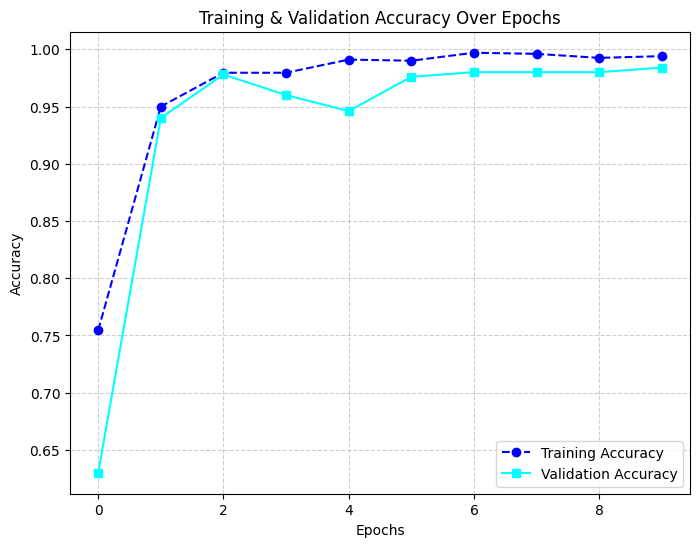

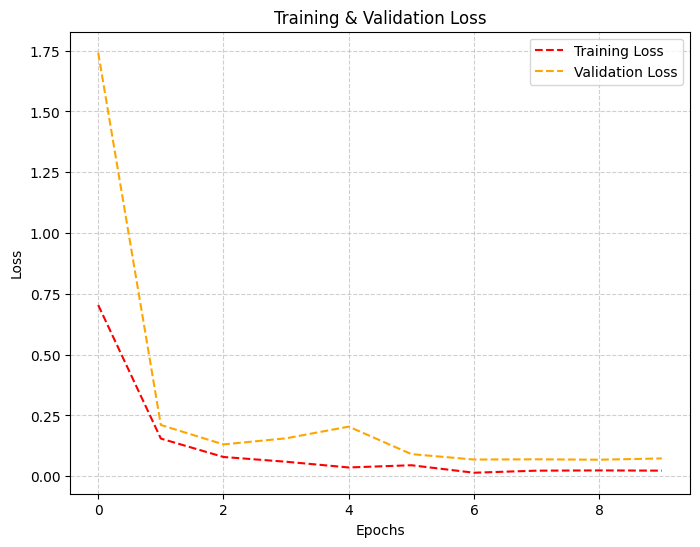

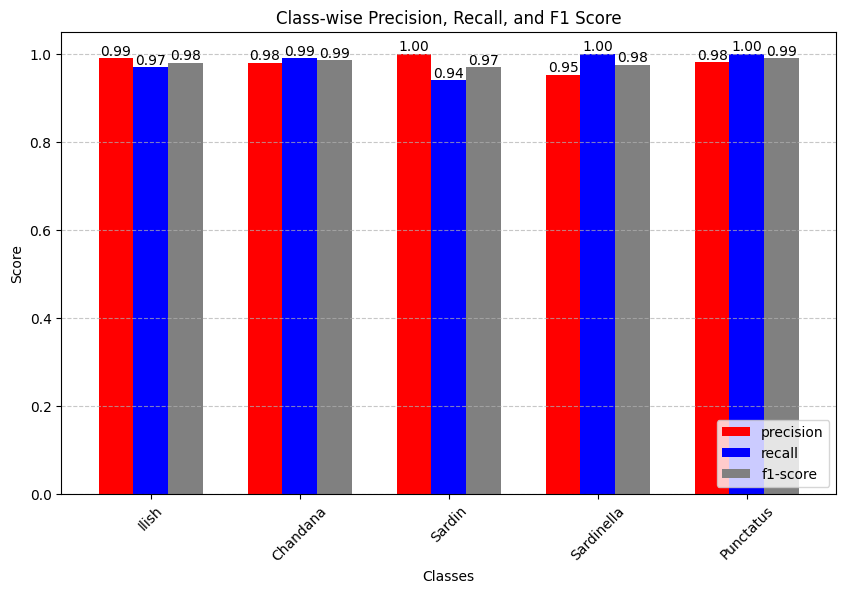


Final Model Performance:
Test Accuracy: 0.9800
F1 Score: 0.9799
Final predictions evaluated.


In [ ]:
!pip install imbalanced-learn

# Data Processing and Model Evaluation
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score, classification_report
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter



# Assuming X and Y are your image data and labels
# X: image data (e.g., shape=(n_samples, height, width, channels)), Y: labels (0,1,2,3,4 for the 5 classes)

# Split original dataset into train & test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Flatten the image data (from 4D to 2D)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE on training data only
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_reshaped, Y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(Y_train_resampled))

# Reshape back to original 3D shape for the ResNet50 model
# Reshape X_train_resampled and X_test to have the shape (n_samples, 224, 224, 3)
X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)


# X_train_resampled = X_train_resampled / 255.0  # Normalize train data
# X_test = X_test / 255.0  # Normalize test data



print(f"Shape of X_train_resampled: {X_train_resampled.shape}")  # Check the new shape
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")  # Check the new shape









# Model Training
# Initialize ResNet50 model with transfer learning (keeping its layers frozen)
input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers of ResNet50 to use as a feature extractor
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)  # 5 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)














# Train Model
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_test, Y_test),
                    epochs=10, batch_size=32, verbose=1,
                    callbacks=[early_stop, lr_reduce, model_checkpoint])

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate Predictions
Y_test_pred_prob = model.predict(X_test)
Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)





# Rest of your evaluation code...

# Define class labels
# class_labels = [f'Class {i}' for i in range(5)]
class_labels=['Ilish','Chandana','Sardin','Sardinella','Punctatus']

# Custom callback to track learning rate during training
class LRSchedulerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if 'lr' not in self.model.history.history:
            self.model.history.history['lr'] = []
        self.model.history.history['lr'].append(self.model.optimizer.lr.numpy())

# Function to display individual plots

# ROC Curve Plot
def plot_roc_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        y_true_binary = (Y_test == i).astype(int)
        y_score = Y_test_pred_prob[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(Y_test, Y_test_pred, class_labels):
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        precision, recall, _ = precision_recall_curve((Y_test == i).astype(int), Y_test_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Training & Validation Accuracy Plot
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue',linestyle='dashed', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', marker='s')
    plt.title('Training & Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Training & Validation Loss Plot
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', linestyle='dashed', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed', color='orange')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Learning Rate Scheduler Plot
def plot_learning_rate(history):
    if 'lr' in history.history:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='purple')
        plt.title('Learning Rate Scheduler')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

# Class-wise Precision, Recall, F1 Score Plot with Values
def plot_classwise_metrics(Y_test, Y_test_pred, class_labels):
    report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)

    # Remove overall accuracy key
    if 'accuracy' in report:
        report.pop('accuracy')

    df_report = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])  # Remove avg rows
    df_report = df_report[['precision', 'recall', 'f1-score']]  # Keep relevant columns

    # Define colors for bars
    colors = {'precision': 'red', 'recall': 'blue', 'f1-score': 'gray'}

    # Plot grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    df_report.plot(kind='bar', ax=ax, width=0.7, color=[colors[col] for col in df_report.columns])

    # Annotate bars with values in normal font
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='normal', color='black')

    plt.title('Class-wise Precision, Recall, and F1 Score')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.xticks(rotation=45)

    # Move legend inside the plot (upper left)
    plt.legend(loc='lower right', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



# Generate all individual plots
plot_roc_curve(Y_test, Y_test_pred_prob, class_labels)
plot_confusion_matrix(Y_test, Y_test_pred, class_labels)
plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels)
plot_accuracy(history)
plot_loss(history)
plot_learning_rate(history)
plot_classwise_metrics(Y_test, Y_test_pred, class_labels)

# Print final metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, Y_test_pred, average='weighted'):.4f}")

print("Final predictions evaluated.")

model.save('model_resnet.keras')

#Single Transfer Model Trianing

#CNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN model...
Epoch 1/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7087 - loss: 1.0063
Epoch 1: val_loss improved from inf to 3.71845, saving model to best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.7093 - loss: 1.0037 - val_accuracy: 0.3023 - val_loss: 3.7185 - learning_rate: 1.0000e-04
Epoch 2/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8966 - loss: 0.3215
Epoch 2: val_loss improved from 3.71845 to 1.11397, saving model to best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.8967 - loss: 0.3212 - val_accuracy: 0.6631 - val_loss: 1.1140 - learning_rate: 1.0000e-04
Epoch 3/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9491 - loss: 0.1588
Epoch 3: val_loss improved from 1.11397 to 0.19062, saving model to best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.9492 - loss: 0.1587 - val_accuracy: 0.9398 - val_loss: 0.1906 - learning_rate: 1.0000e-04
Epoch 4/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9758 - loss: 0.0773
Epoch 4: val_loss did not improve from 0.19062
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9758 - loss: 0.0774 - val_accuracy: 0.9182 - val_loss: 0.2804 - learning_rate: 1.0000e-04
Epoch 5/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9833 - loss: 0.0557
Epoch 5: val_loss did not improve from 0.19062
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9833 - loss: 0.0556 - val_accuracy: 0.9284 - val_loss: 0.2379 - learning_rate: 1.0000e-04
Epoch 6/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9908 - loss: 0.0313
Epoch 6: val_loss improved from 0.19062 to 0.18022, saving model to best_model.h5


220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.9908 - loss: 0.0313 - val_accuracy: 0.9432 - val_loss: 0.1802 - learning_rate: 1.0000e-04
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9913 - loss: 0.0292
Epoch 7: val_loss did not improve from 0.18022
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9913 - loss: 0.0292 - val_accuracy: 0.9449 - val_loss: 0.1920 - learning_rate: 1.0000e-04
Epoch 8/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9951 - loss: 0.0217
Epoch 8: val_loss did not improve from 0.18022
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9951 - loss: 0.0217 - val_accuracy: 0.9540 - val_loss: 0.1802 - learning_rate: 1.0000e-04
Epoch 9/10
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9947 - loss: 0.0189
Epoch 9: val_loss did not improve from 0.18022
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9948 - loss: 0.0189 - val_accuracy: 0.9358 - val_loss: 0.1981 - learning_rate: 1.0000e-04
Epoch 10/1

220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.9963 - loss: 0.0130 - val_accuracy: 0.9625 - val_loss: 0.1340 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


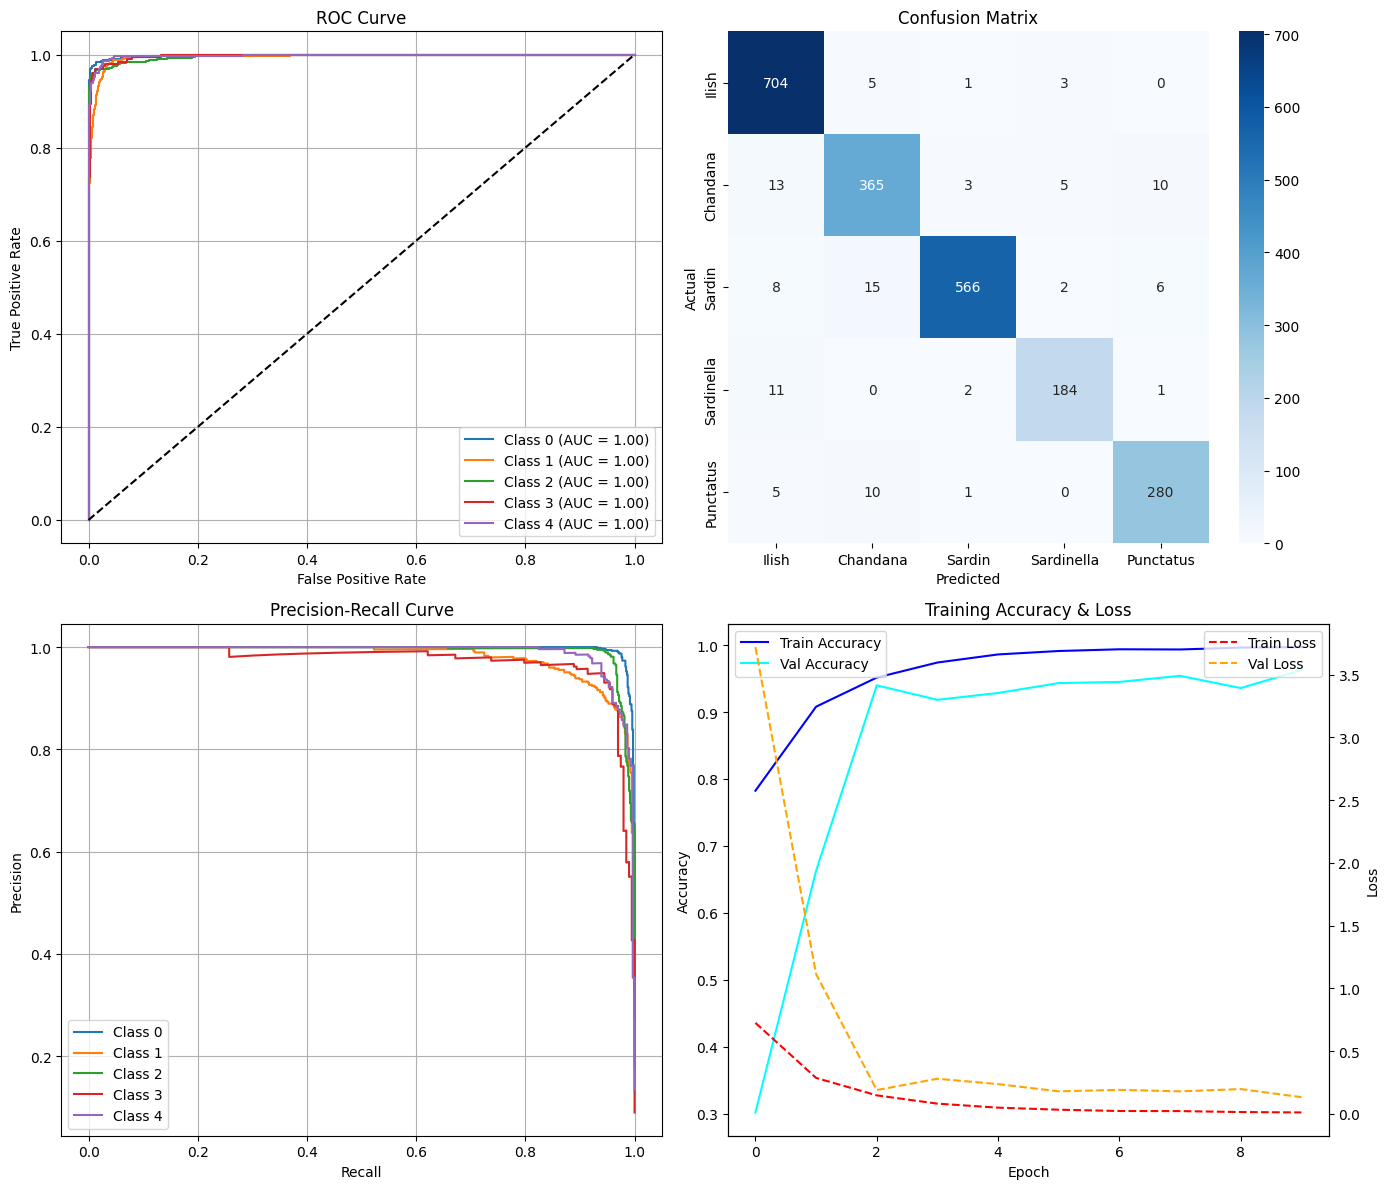


Final Model Performance:
Test Accuracy: 0.9541
F1 Score: 0.9541
Final predictions evaluated.


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score

# Define class labels
class_labels = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']


# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1)  # Adjusted patience
callbacks = [checkpoint, earlystop, reduce_lr]

# Function to create a base CNN model
def create_base_cnn_model(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Third convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Ensure dataset variables exist
# (You need to define X_train_scaled, X_test_scaled, Y_train, Y_test before running)

# Create the CNN model
cnn_model = create_base_cnn_model()

# Train the model
print("Training CNN model...")
history_cnn = cnn_model.fit(X_train_scaled, Y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2, callbacks=callbacks)

# Generate predictions
cnn_preds_prob = cnn_model.predict(X_test_scaled)
cnn_preds = np.argmax(cnn_preds_prob, axis=1)

# Visualization function
def plot_all_visualizations(Y_test, Y_test_pred, Y_test_pred_prob, history, class_labels):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # ROC Curve
    for i in range(5):
        y_true_binary = (Y_test == i).astype(int)
        y_score = Y_test_pred_prob[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        axes[0, 0].plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    axes[0, 0].plot([0, 1], [0, 1], 'k--')
    axes[0, 0].set_title('ROC Curve')
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Confusion Matrix
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[0, 1])
    axes[0, 1].set_title('Confusion Matrix')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')

    # Precision-Recall Curve
    for i in range(5):
        precision, recall, _ = precision_recall_curve((Y_test == i).astype(int), Y_test_pred_prob[:, i])
        axes[1, 0].plot(recall, precision, label=f'Class {i}')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Training Accuracy & Loss Curves
    ax2 = axes[1, 1].twinx()
    axes[1, 1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axes[1, 1].plot(history.history['val_accuracy'], label='Val Accuracy', color='cyan')
    ax2.plot(history.history['loss'], label='Train Loss', linestyle='dashed', color='red')
    ax2.plot(history.history['val_loss'], label='Val Loss', linestyle='dashed', color='orange')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    ax2.set_ylabel('Loss')
    axes[1, 1].set_title('Training Accuracy & Loss')
    axes[1, 1].legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Generate all visualizations
plot_all_visualizations(Y_test, cnn_preds, cnn_preds_prob, history_cnn, class_labels)

# Print final metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, cnn_preds):.4f}")
print(f"F1 Score: {f1_score(Y_test, cnn_preds, average='weighted'):.4f}")

print("Final predictions evaluated.")

#ResNet50

Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7836 - loss: 0.6548
Epoch 1: val_loss improved from inf to 2.54830, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 125s 186ms/step - accuracy: 0.7840 - loss: 0.6535 - val_accuracy: 0.1350 - val_loss: 2.5483 - learning_rate: 1.0000e-04
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9784 - loss: 0.0734
Epoch 2: val_loss improved from 2.54830 to 1.82085, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 43s 157ms/step - accuracy: 0.9784 - loss: 0.0734 - val_accuracy: 0.2136 - val_loss: 1.8209 - learning_rate: 1.0000e-04
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9892 - loss: 0.0431
Epoch 3: val_loss improved from 1.82085 to 0.49696, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 43s 158ms/step - accuracy: 0.9892 - loss: 0.0430 - val_accuracy: 0.8486 - val_loss: 0.4970 - learning_rate: 1.0000e-04
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step -

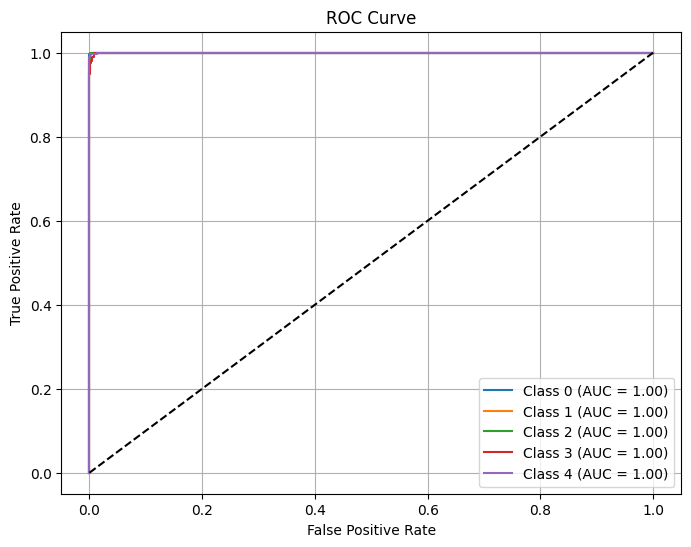

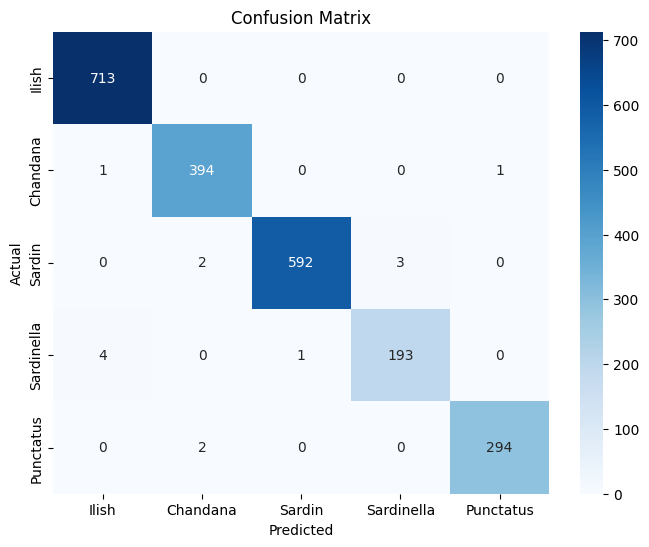

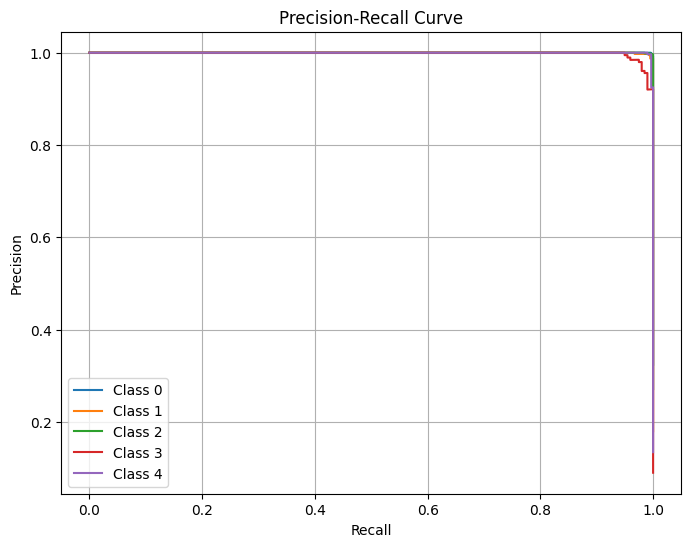

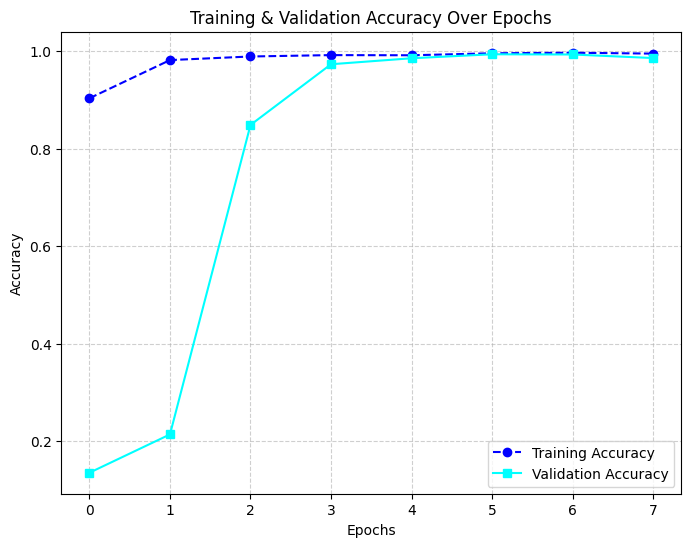

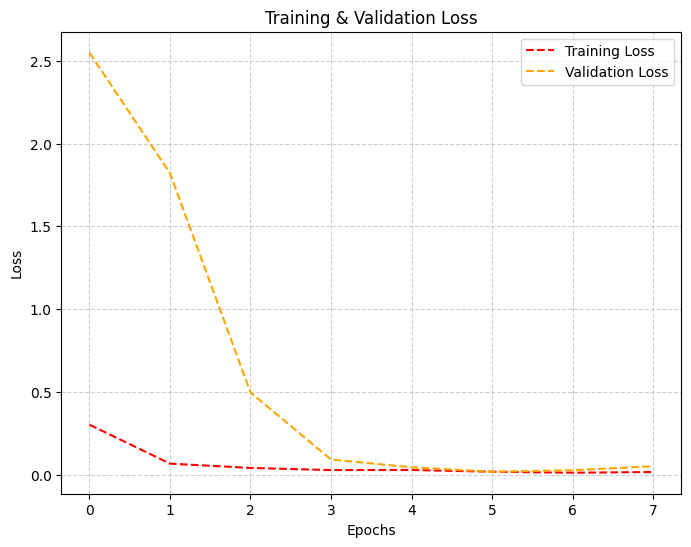

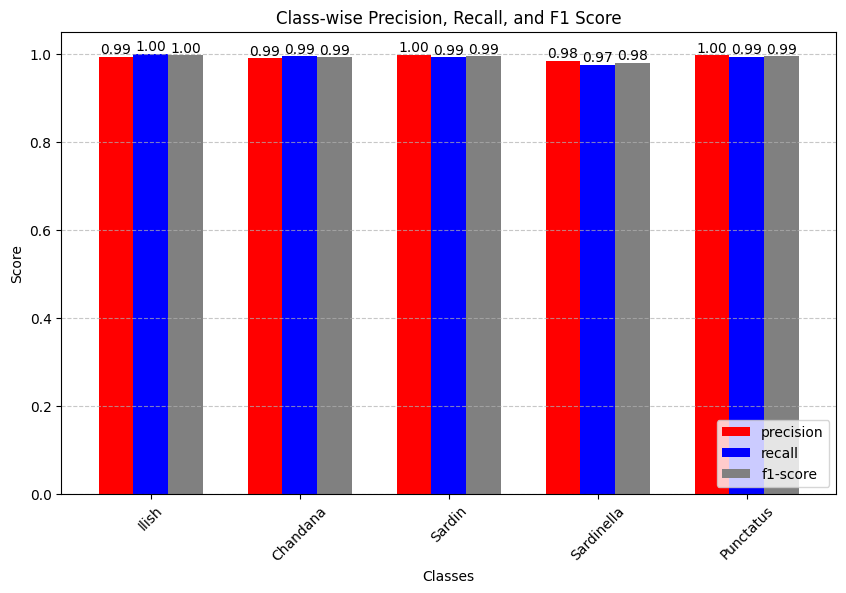


Final Model Performance:
Test Accuracy: 0.9936
F1 Score: 0.9936
Final predictions evaluated.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, classification_report
import seaborn as sns
import pandas as pd

# Initialize ResNet50 model with transfer learning (keeping its layers frozen)
input_shape = (224, 224, 3)
# from tensorflow.keras.applications import
# [
# ResNet50, ResNet101, ResNet152,
# EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
# VGG16, VGG19,
# Xception,
# InceptionV3, InceptionResNetV2,
# DenseNet121, DenseNet169, DenseNet201,
# MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large,
# NASNetLarge, NASNetMobile
# ]
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers of ResNet50 to use as a feature extractor
# for layer in base_model.layers[-20:]:
#     layer.trainable = True


# Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)  # 5 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train Model
history = model.fit(X_train_scaled, Y_train,
                    validation_data=(X_test_scaled, Y_test),
                    epochs=10, batch_size=32, verbose=1,
                    callbacks=[early_stop, lr_reduce, model_checkpoint])

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_test_scaled, Y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate Predictions
Y_test_pred_prob = model.predict(X_test_scaled)
Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)

# Define class labels
# class_labels = [f'Class {i}' for i in range(5)]
class_labels=['Ilish','Chandana','Sardin','Sardinella','Punctatus']

# Custom callback to track learning rate during training
class LRSchedulerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if 'lr' not in self.model.history.history:
            self.model.history.history['lr'] = []
        self.model.history.history['lr'].append(self.model.optimizer.lr.numpy())

# Function to display individual plots

# ROC Curve Plot
def plot_roc_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        y_true_binary = (Y_test == i).astype(int)
        y_score = Y_test_pred_prob[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(Y_test, Y_test_pred, class_labels):
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        precision, recall, _ = precision_recall_curve((Y_test == i).astype(int), Y_test_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Training & Validation Accuracy Plot
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue',linestyle='dashed', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', marker='s')
    plt.title('Training & Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Training & Validation Loss Plot
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', linestyle='dashed', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed', color='orange')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Learning Rate Scheduler Plot
def plot_learning_rate(history):
    if 'lr' in history.history:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='purple')
        plt.title('Learning Rate Scheduler')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

# Class-wise Precision, Recall, F1 Score Plot with Values
def plot_classwise_metrics(Y_test, Y_test_pred, class_labels):
    report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)

    # Remove overall accuracy key
    if 'accuracy' in report:
        report.pop('accuracy')

    df_report = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])  # Remove avg rows
    df_report = df_report[['precision', 'recall', 'f1-score']]  # Keep relevant columns

    # Define colors for bars
    colors = {'precision': 'red', 'recall': 'blue', 'f1-score': 'gray'}

    # Plot grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    df_report.plot(kind='bar', ax=ax, width=0.7, color=[colors[col] for col in df_report.columns])

    # Annotate bars with values in normal font
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='normal', color='black')

    plt.title('Class-wise Precision, Recall, and F1 Score')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.xticks(rotation=45)

    # Move legend inside the plot (upper left)
    plt.legend(loc='lower right', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



# Generate all individual plots
plot_roc_curve(Y_test, Y_test_pred_prob, class_labels)
plot_confusion_matrix(Y_test, Y_test_pred, class_labels)
plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels)
plot_accuracy(history)
plot_loss(history)
plot_learning_rate(history)
plot_classwise_metrics(Y_test, Y_test_pred, class_labels)

# Print final metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, Y_test_pred, average='weighted'):.4f}")

print("Final predictions evaluated.")

model.save('model_resnet.keras')


# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, classification_report
# import seaborn as sns
# import pandas as pd

# # Initialize ResNet50 model with transfer learning
# input_shape = (224, 224, 3)
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


# # Custom Classification Head
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)

# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)

# output = Dense(5, activation='softmax')(x)  # 5 classes

# # Create the final model
# model = Model(inputs=base_model.input, outputs=output)

# # Compile Model
# model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Callbacks
# early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-6, verbose=1)
# model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# # Train Model
# history = model.fit(X_train_scaled, Y_train,
#                     validation_data=(X_test_scaled, Y_test),
#                     epochs=10, batch_size=32, verbose=1,
#                     callbacks=[early_stop, lr_reduce, model_checkpoint])

# # Evaluate Model
# val_loss, val_accuracy = model.evaluate(X_test_scaled, Y_test, verbose=0)
# print(f"Validation Accuracy: {val_accuracy:.4f}")

# # Generate Predictions
# Y_test_pred_prob = model.predict(X_test)
# Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, classification_report
import seaborn as sns
import pandas as pd

# Initialize ResNet50 model with transfer learning
input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


# Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)  # 5 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train Model
history = model.fit(X_train_scaled, Y_train,
                    validation_data=(X_test_scaled, Y_test),
                    epochs=10, batch_size=32, verbose=1,
                    callbacks=[early_stop, lr_reduce, model_checkpoint])

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_test_scaled, Y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate Predictions
Y_test_pred_prob = model.predict(X_test)
Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)

Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7631 - loss: 0.6585
Epoch 1: val_loss improved from inf to 6.14701, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 128s 205ms/step - accuracy: 0.7635 - loss: 0.6572 - val_accuracy: 0.1800 - val_loss: 6.1470 - learning_rate: 1.0000e-04
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9596 - loss: 0.1255
Epoch 2: val_loss improved from 6.14701 to 1.94512, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 44s 158ms/step - accuracy: 0.9596 - loss: 0.1254 - val_accuracy: 0.2786 - val_loss: 1.9451 - learning_rate: 1.0000e-04
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9850 - loss: 0.0482
Epoch 3: val_loss improved from 1.94512 to 0.64655, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 44s 159ms/step - accuracy: 0.9850 - loss: 0.0482 - val_accuracy: 0.8195 - val_loss: 0.6465 - learning_rate: 1.0000e-04
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step -

#EfficientNetB0

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6188 - loss: 1.0592
Epoch 1: val_loss improved from inf to 0.07323, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 126s 130ms/step - accuracy: 0.6195 - loss: 1.0573 - val_accuracy: 0.9755 - val_loss: 0.0732 - learning_rate: 1.0000e-04
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9653 - loss: 0.1058
Epoch 2: val_loss improved from 0.07323 to 0.04252, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.9653 - loss: 0.1058 - val_accuracy: 0.9864 - val_loss: 0.0425 - learning_rate: 1.0000e-04
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9803 - loss: 0.0563
Epoch 3: val_loss improved from 0.04252 to 0.02860, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.9803 - loss: 0.0563 - val_accuracy: 0.9877 - val_loss: 0.0286 - learning_rate: 1.0000e-04
Epoch 4/1

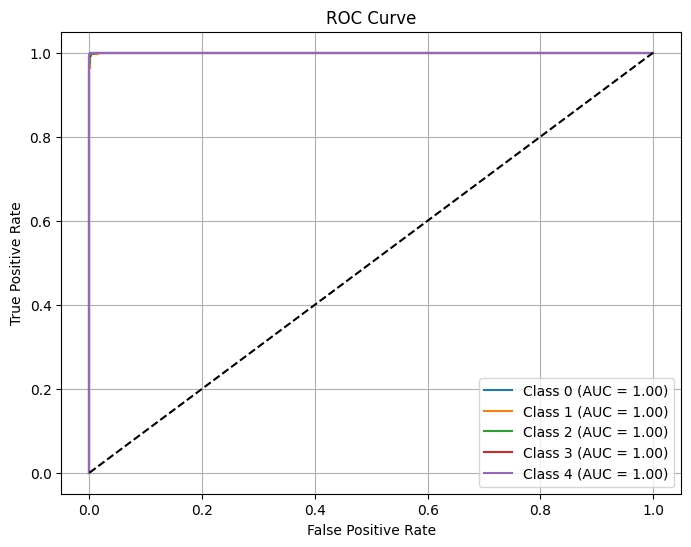

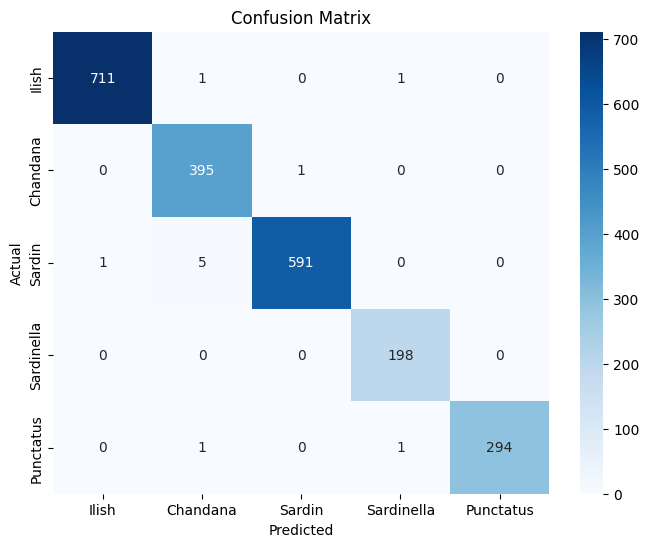

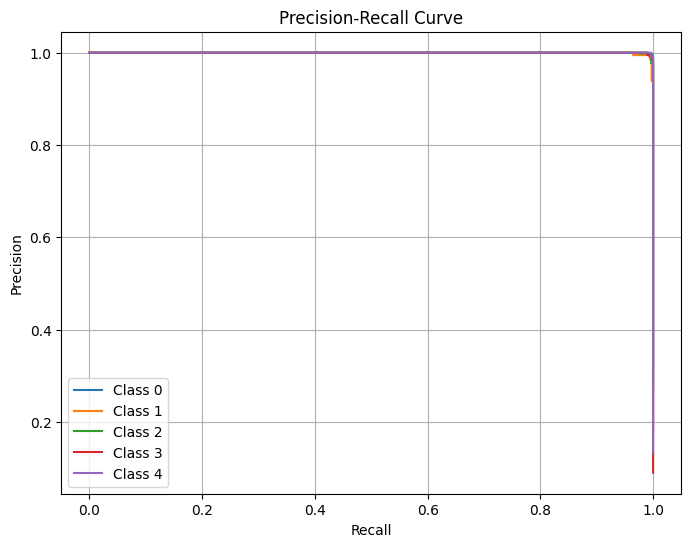

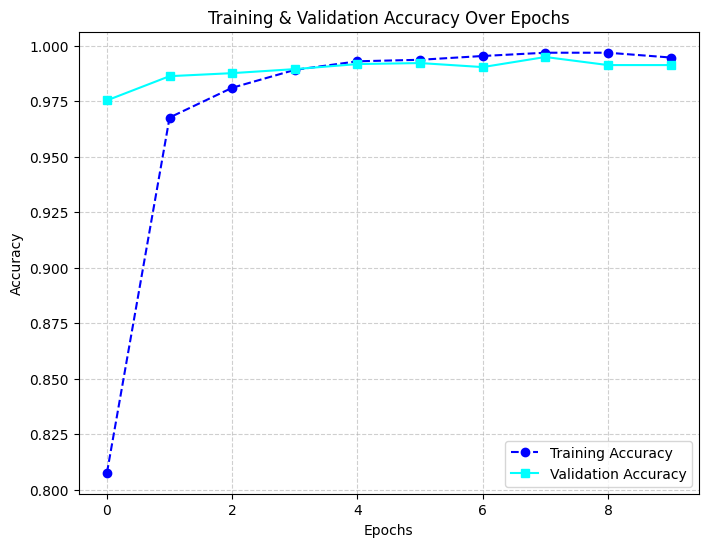

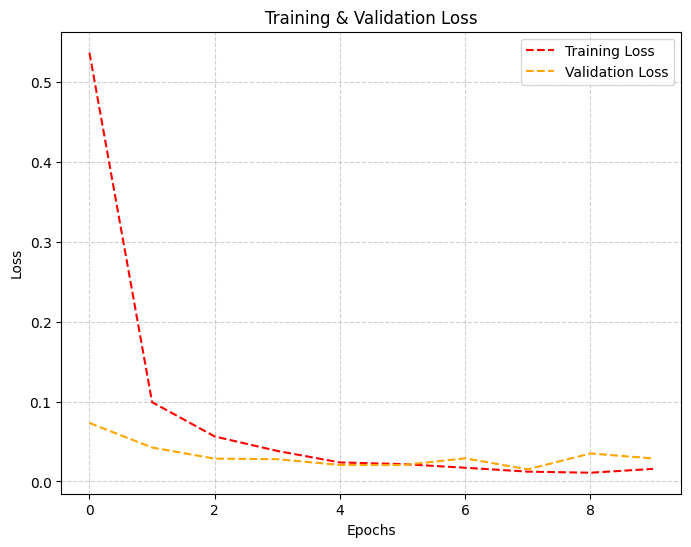

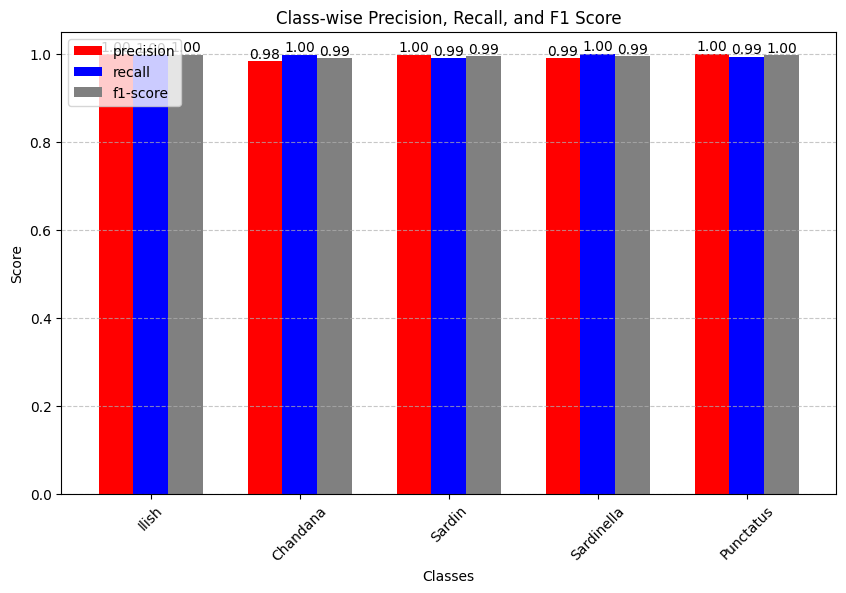


Final Model Performance:
Test Accuracy: 0.9950
F1 Score: 0.9950
Final predictions evaluated.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, classification_report
import seaborn as sns
import pandas as pd

# Initialize ResNet50 model with transfer learning (keeping its layers frozen)
input_shape = (224, 224, 3)
# from tensorflow.keras.applications import
# [
# ResNet50, ResNet101, ResNet152,
# EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
# VGG16, VGG19,
# Xception,
# InceptionV3, InceptionResNetV2,
# DenseNet121, DenseNet169, DenseNet201,
# MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large,
# NASNetLarge, NASNetMobile
# ]
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers of ResNet50 to use as a feature extractor
for layer in base_model.layers[:-20]:
    layer.trainable = True

# Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)  # 5 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train Model
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=10, batch_size=32, verbose=1,
                    callbacks=[early_stop, lr_reduce, model_checkpoint])

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate Predictions
Y_test_pred_prob = model.predict(X_test)
Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)

# Define class labels
# class_labels = [f'Class {i}' for i in range(5)]
class_labels=['Ilish','Chandana','Sardin','Sardinella','Punctatus']

# Custom callback to track learning rate during training
class LRSchedulerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if 'lr' not in self.model.history.history:
            self.model.history.history['lr'] = []
        self.model.history.history['lr'].append(self.model.optimizer.lr.numpy())

# Function to display individual plots

# ROC Curve Plot
def plot_roc_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        y_true_binary = (Y_test == i).astype(int)
        y_score = Y_test_pred_prob[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(Y_test, Y_test_pred, class_labels):
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        precision, recall, _ = precision_recall_curve((Y_test == i).astype(int), Y_test_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Training & Validation Accuracy Plot
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue',linestyle='dashed', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', marker='s')
    plt.title('Training & Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Training & Validation Loss Plot
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', linestyle='dashed', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed', color='orange')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Learning Rate Scheduler Plot
def plot_learning_rate(history):
    if 'lr' in history.history:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='purple')
        plt.title('Learning Rate Scheduler')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

# Class-wise Precision, Recall, F1 Score Plot with Values
def plot_classwise_metrics(Y_test, Y_test_pred, class_labels):
    report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)

    # Remove overall accuracy key
    if 'accuracy' in report:
        report.pop('accuracy')

    df_report = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])  # Remove avg rows
    df_report = df_report[['precision', 'recall', 'f1-score']]  # Keep relevant columns

    # Define colors for bars
    colors = {'precision': 'red', 'recall': 'blue', 'f1-score': 'gray'}

    # Plot grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    df_report.plot(kind='bar', ax=ax, width=0.7, color=[colors[col] for col in df_report.columns])

    # Annotate bars with values in normal font
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='normal', color='black')

    plt.title('Class-wise Precision, Recall, and F1 Score')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.xticks(rotation=45)

    # Move legend inside the plot (upper left)
    plt.legend(loc='upper left', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



# Generate all individual plots
plot_roc_curve(Y_test, Y_test_pred_prob, class_labels)
plot_confusion_matrix(Y_test, Y_test_pred, class_labels)
plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels)
plot_accuracy(history)
plot_loss(history)
plot_learning_rate(history)
plot_classwise_metrics(Y_test, Y_test_pred, class_labels)

# Print final metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, Y_test_pred, average='weighted'):.4f}")

print("Final predictions evaluated.")

#InceptionV3

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7387 - loss: 0.7286
Epoch 1: val_loss improved from inf to 0.11232, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 123s 144ms/step - accuracy: 0.7392 - loss: 0.7272 - val_accuracy: 0.9636 - val_loss: 0.1123 - learning_rate: 1.0000e-04
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9701 - loss: 0.0883
Epoch 2: val_loss improved from 0.11232 to 0.05392, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.9701 - loss: 0.0883 - val_accuracy: 0.9832 - val_loss: 0.0539 - learning_rate: 1.0000e-04
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9864 - loss: 0.0412
Epoch 3: val_loss improved from 0.05392 to 0.03985, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.9864 - loss: 0.0412 - val_accuracy: 0.9855 - val_loss: 0.0398 - learning_rate: 1.0000e-04
Epoch 4/1

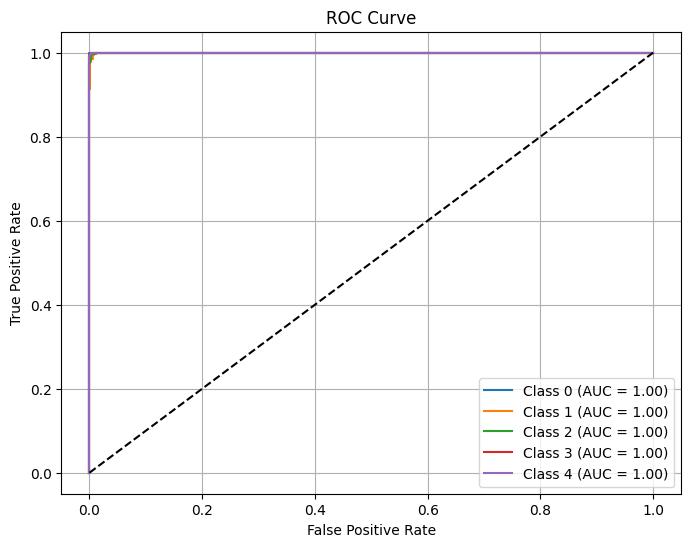

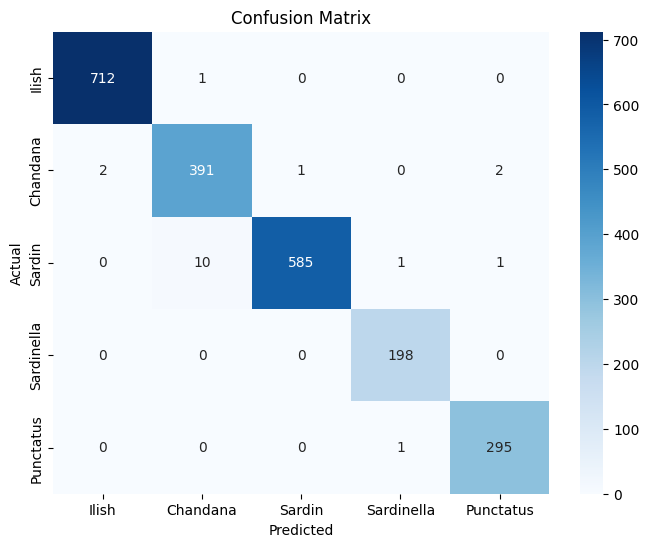

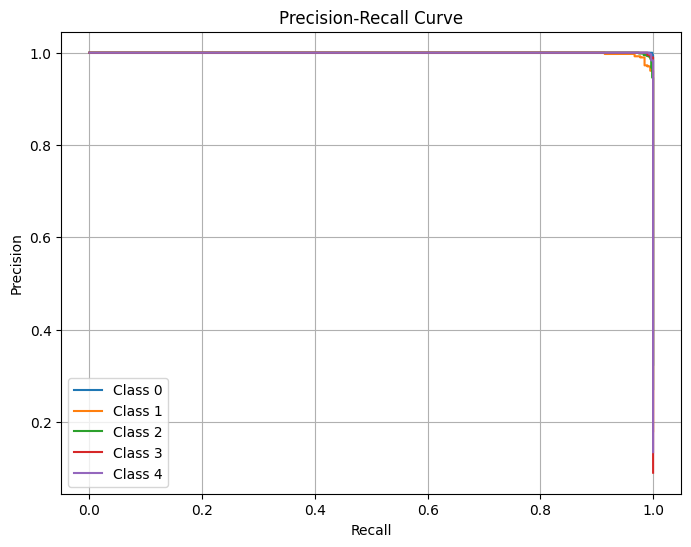

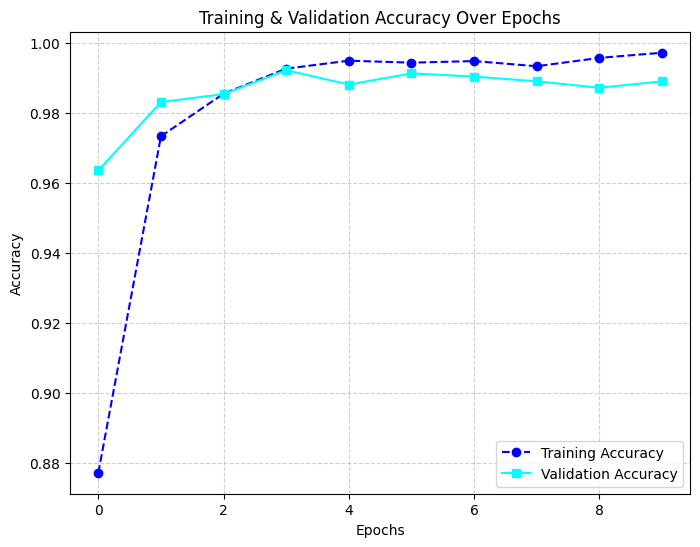

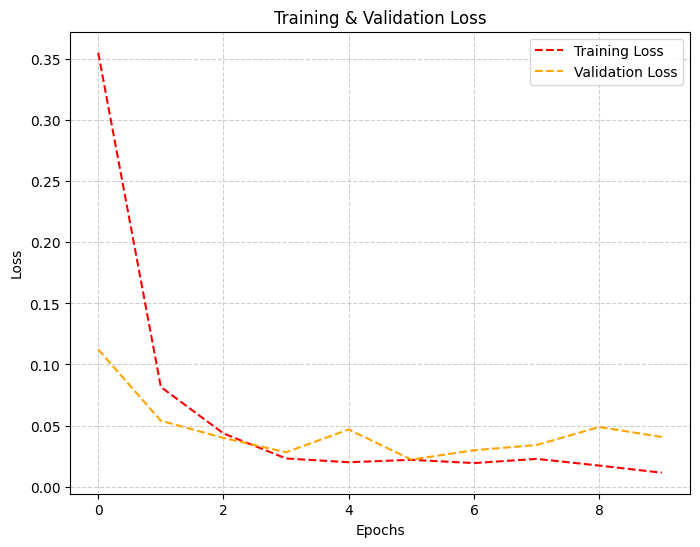

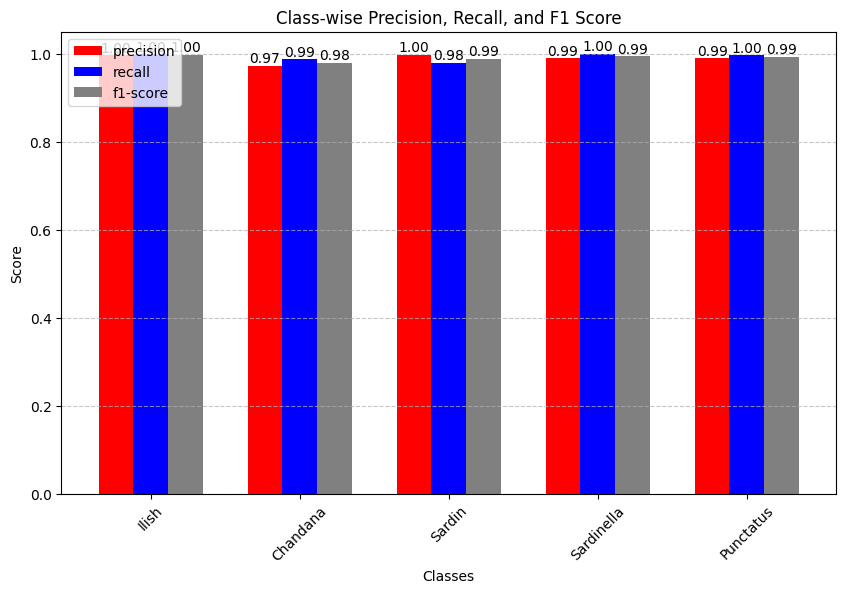


Final Model Performance:
Test Accuracy: 0.9914
F1 Score: 0.9914
Final predictions evaluated.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, classification_report
import seaborn as sns
import pandas as pd

# Initialize ResNet50 model with transfer learning (keeping its layers frozen)
input_shape = (224, 224, 3)
# from tensorflow.keras.applications import
# [
# ResNet50, ResNet101, ResNet152,
# EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
# VGG16, VGG19,
# Xception,
# InceptionV3, InceptionResNetV2,
# DenseNet121, DenseNet169, DenseNet201,
# MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large,
# NASNetLarge, NASNetMobile
# ]
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers of ResNet50 to use as a feature extractor
for layer in base_model.layers[:-20]:
    layer.trainable = True

# Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)  # 5 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train Model
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=10, batch_size=32, verbose=1,
                    callbacks=[early_stop, lr_reduce, model_checkpoint])

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate Predictions
Y_test_pred_prob = model.predict(X_test)
Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)

# Define class labels
# class_labels = [f'Class {i}' for i in range(5)]
class_labels=['Ilish','Chandana','Sardin','Sardinella','Punctatus']

# Custom callback to track learning rate during training
class LRSchedulerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if 'lr' not in self.model.history.history:
            self.model.history.history['lr'] = []
        self.model.history.history['lr'].append(self.model.optimizer.lr.numpy())

# Function to display individual plots

# ROC Curve Plot
def plot_roc_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        y_true_binary = (Y_test == i).astype(int)
        y_score = Y_test_pred_prob[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(Y_test, Y_test_pred, class_labels):
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        precision, recall, _ = precision_recall_curve((Y_test == i).astype(int), Y_test_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Training & Validation Accuracy Plot
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue',linestyle='dashed', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', marker='s')
    plt.title('Training & Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Training & Validation Loss Plot
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', linestyle='dashed', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed', color='orange')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Learning Rate Scheduler Plot
def plot_learning_rate(history):
    if 'lr' in history.history:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='purple')
        plt.title('Learning Rate Scheduler')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

# Class-wise Precision, Recall, F1 Score Plot with Values
def plot_classwise_metrics(Y_test, Y_test_pred, class_labels):
    report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)

    # Remove overall accuracy key
    if 'accuracy' in report:
        report.pop('accuracy')

    df_report = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])  # Remove avg rows
    df_report = df_report[['precision', 'recall', 'f1-score']]  # Keep relevant columns

    # Define colors for bars
    colors = {'precision': 'red', 'recall': 'blue', 'f1-score': 'gray'}

    # Plot grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    df_report.plot(kind='bar', ax=ax, width=0.7, color=[colors[col] for col in df_report.columns])

    # Annotate bars with values in normal font
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='normal', color='black')

    plt.title('Class-wise Precision, Recall, and F1 Score')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.xticks(rotation=45)

    # Move legend inside the plot (upper left)
    plt.legend(loc='upper left', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



# Generate all individual plots
plot_roc_curve(Y_test, Y_test_pred_prob, class_labels)
plot_confusion_matrix(Y_test, Y_test_pred, class_labels)
plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels)
plot_accuracy(history)
plot_loss(history)
plot_learning_rate(history)
plot_classwise_metrics(Y_test, Y_test_pred, class_labels)

# Print final metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, Y_test_pred, average='weighted'):.4f}")

print("Final predictions evaluated.")

#MobileNetV2

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6957 - loss: 0.8698
Epoch 1: val_loss improved from inf to 2.53476, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.6963 - loss: 0.8682 - val_accuracy: 0.4705 - val_loss: 2.5348 - learning_rate: 1.0000e-04
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9681 - loss: 0.0940
Epoch 2: val_loss improved from 2.53476 to 0.68906, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.9681 - loss: 0.0939 - val_accuracy: 0.7755 - val_loss: 0.6891 - learning_rate: 1.0000e-04
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9778 - loss: 0.0621
Epoch 3: val_loss improved from 0.68906 to 0.16901, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.9778 - loss: 0.0620 - val_accuracy: 0.9377 - val_loss: 0.1690 - learning_rate: 1.0000e-04
Epoch 4/10
27

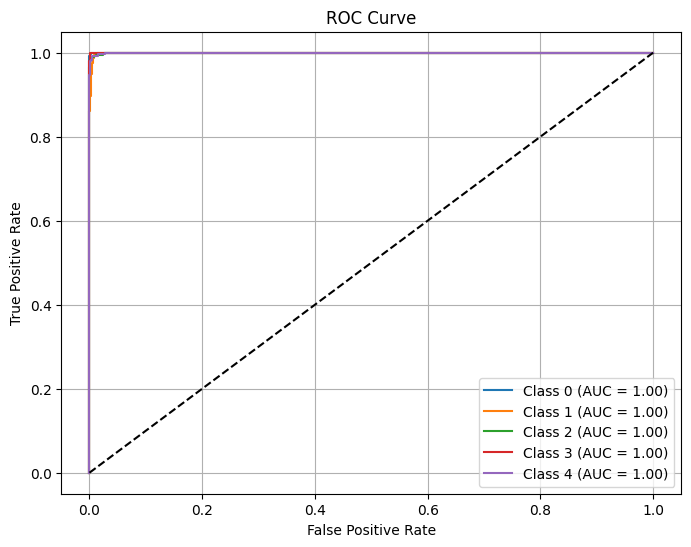

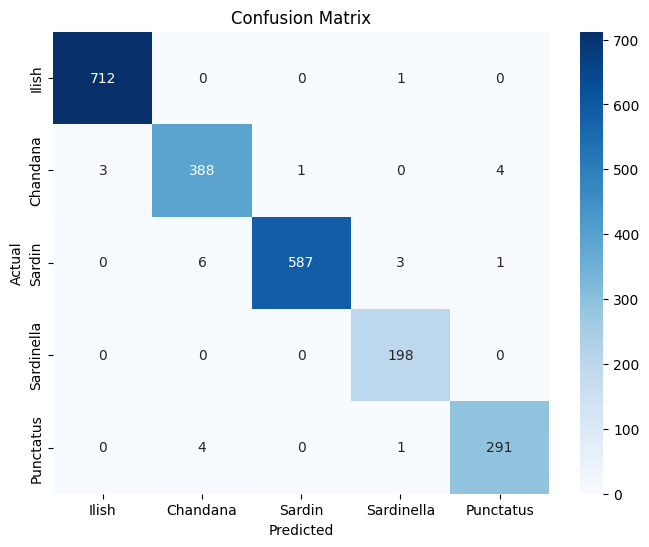

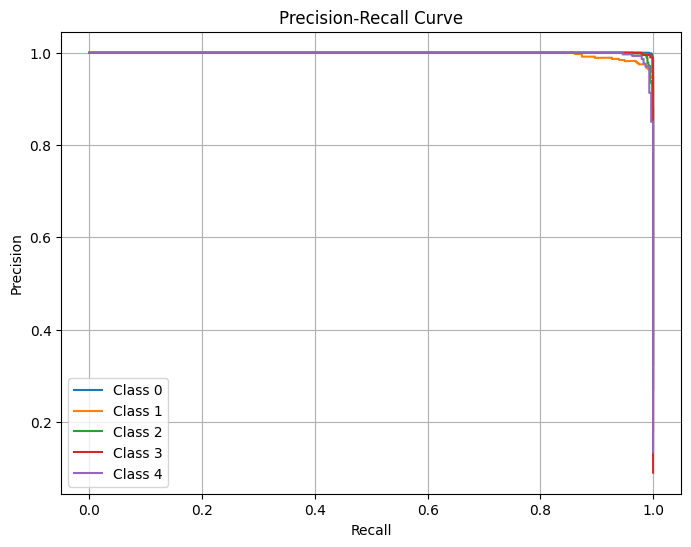

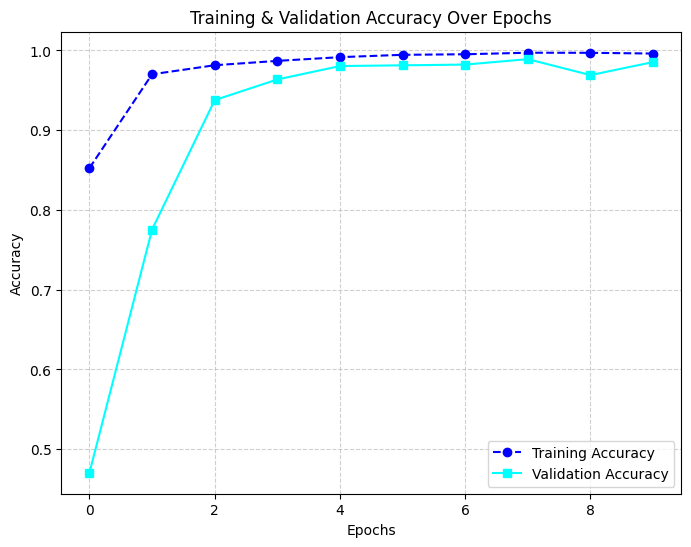

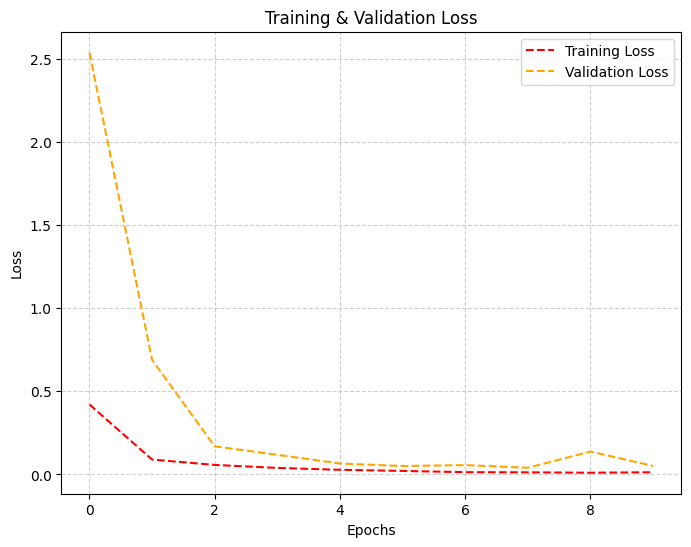

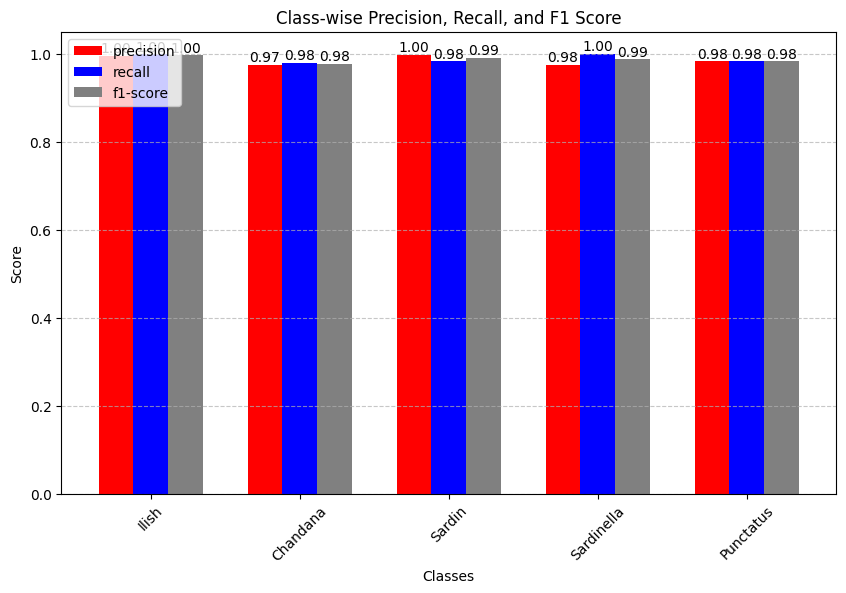


Final Model Performance:
Test Accuracy: 0.9891
F1 Score: 0.9891
Final predictions evaluated.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, classification_report
import seaborn as sns
import pandas as pd

# Initialize ResNet50 model with transfer learning (keeping its layers frozen)
input_shape = (224, 224, 3)
# from tensorflow.keras.applications import
# [
# ResNet50, ResNet101, ResNet152,
# EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
# VGG16, VGG19,
# Xception,
# InceptionV3, InceptionResNetV2,
# DenseNet121, DenseNet169, DenseNet201,
# MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large,
# NASNetLarge, NASNetMobile
# ]
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers of ResNet50 to use as a feature extractor
for layer in base_model.layers[:-20]:
    layer.trainable = True

# Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)  # 5 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train Model
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=10, batch_size=32, verbose=1,
                    callbacks=[early_stop, lr_reduce, model_checkpoint])

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate Predictions
Y_test_pred_prob = model.predict(X_test)
Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)

# Define class labels
# class_labels = [f'Class {i}' for i in range(5)]
class_labels=['Ilish','Chandana','Sardin','Sardinella','Punctatus']

# Custom callback to track learning rate during training
class LRSchedulerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if 'lr' not in self.model.history.history:
            self.model.history.history['lr'] = []
        self.model.history.history['lr'].append(self.model.optimizer.lr.numpy())

# Function to display individual plots

# ROC Curve Plot
def plot_roc_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        y_true_binary = (Y_test == i).astype(int)
        y_score = Y_test_pred_prob[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(Y_test, Y_test_pred, class_labels):
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        precision, recall, _ = precision_recall_curve((Y_test == i).astype(int), Y_test_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Training & Validation Accuracy Plot
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue',linestyle='dashed', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', marker='s')
    plt.title('Training & Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Training & Validation Loss Plot
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', linestyle='dashed', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed', color='orange')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Learning Rate Scheduler Plot
def plot_learning_rate(history):
    if 'lr' in history.history:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='purple')
        plt.title('Learning Rate Scheduler')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

# Class-wise Precision, Recall, F1 Score Plot with Values
def plot_classwise_metrics(Y_test, Y_test_pred, class_labels):
    report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)

    # Remove overall accuracy key
    if 'accuracy' in report:
        report.pop('accuracy')

    df_report = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])  # Remove avg rows
    df_report = df_report[['precision', 'recall', 'f1-score']]  # Keep relevant columns

    # Define colors for bars
    colors = {'precision': 'red', 'recall': 'blue', 'f1-score': 'gray'}

    # Plot grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    df_report.plot(kind='bar', ax=ax, width=0.7, color=[colors[col] for col in df_report.columns])

    # Annotate bars with values in normal font
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='normal', color='black')

    plt.title('Class-wise Precision, Recall, and F1 Score')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.xticks(rotation=45)

    # Move legend inside the plot (upper left)
    plt.legend(loc='upper left', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



# Generate all individual plots
plot_roc_curve(Y_test, Y_test_pred_prob, class_labels)
plot_confusion_matrix(Y_test, Y_test_pred, class_labels)
plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels)
plot_accuracy(history)
plot_loss(history)
plot_learning_rate(history)
plot_classwise_metrics(Y_test, Y_test_pred, class_labels)

# Print final metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, Y_test_pred, average='weighted'):.4f}")

print("Final predictions evaluated.")

#VGG-19

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.5926 - loss: 1.1512
Epoch 1: val_loss improved from inf to 1.45339, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 140s 374ms/step - accuracy: 0.5932 - loss: 1.1496 - val_accuracy: 0.6395 - val_loss: 1.4534 - learning_rate: 1.0000e-04
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9245 - loss: 0.2497
Epoch 2: val_loss improved from 1.45339 to 0.85835, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 85s 309ms/step - accuracy: 0.9246 - loss: 0.2496 - val_accuracy: 0.7586 - val_loss: 0.8584 - learning_rate: 1.0000e-04
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9645 - loss: 0.1218
Epoch 3: val_loss improved from 0.85835 to 0.21431, saving model to model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 85s 309ms/step - accuracy: 0.9645 - loss: 0.1218 - val_accuracy: 0.9318 - val_loss: 0.2143 - learning_rate: 1.0000e-04
Epoc

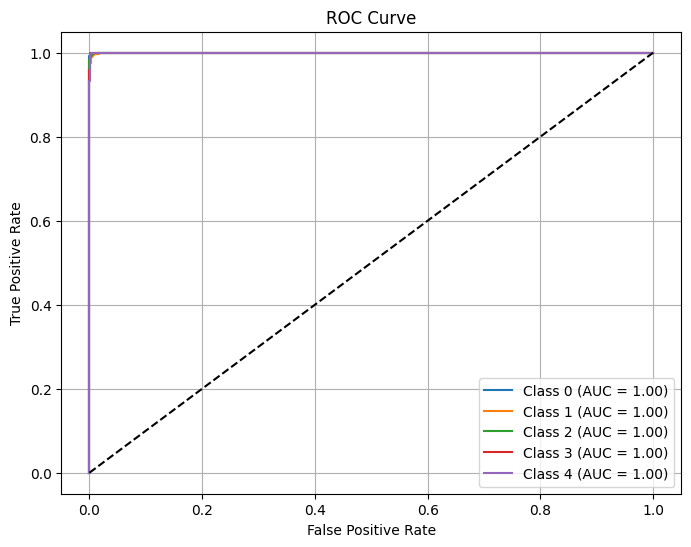

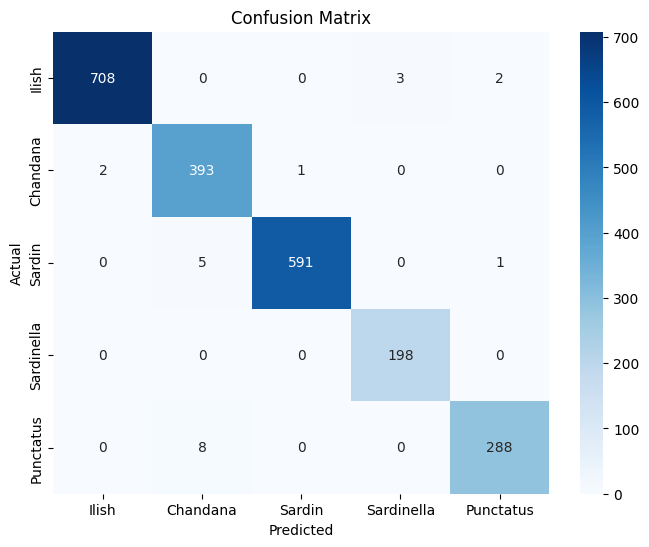

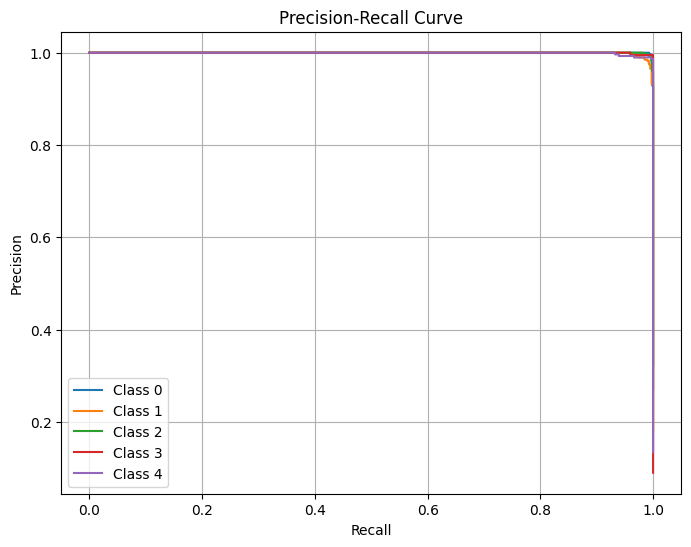

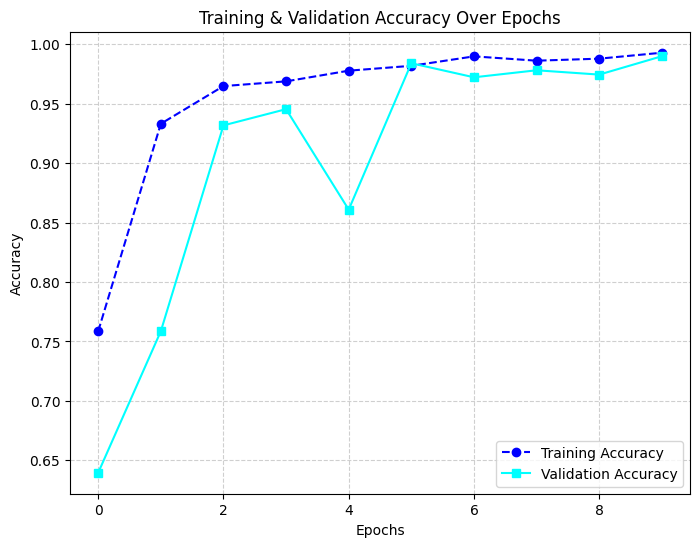

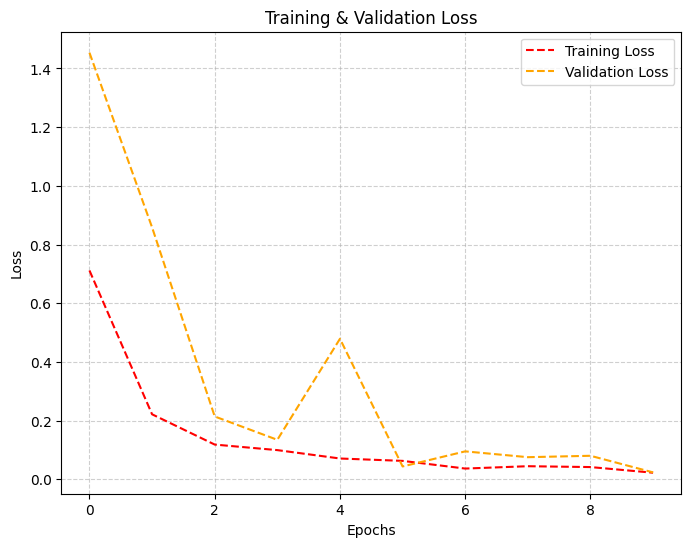

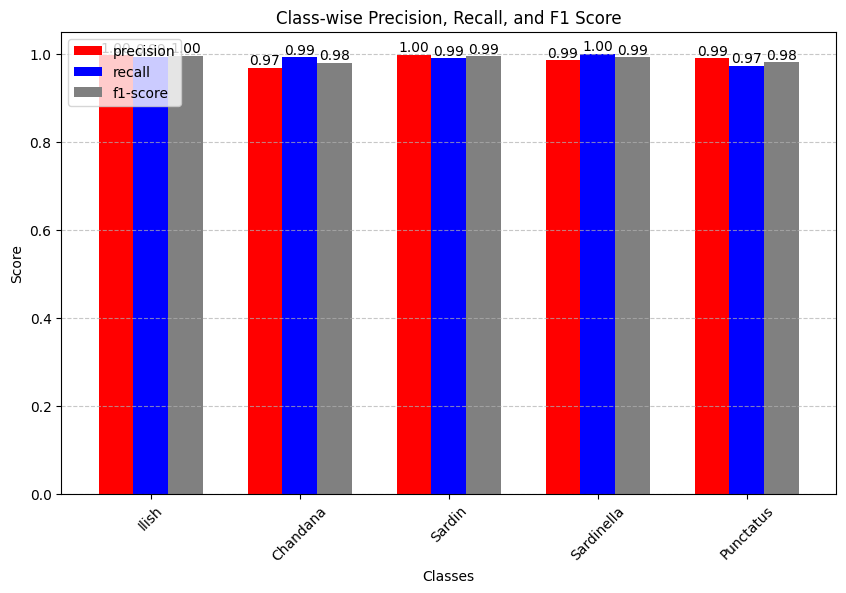


Final Model Performance:
Test Accuracy: 0.9900
F1 Score: 0.9900
Final predictions evaluated.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, classification_report
import seaborn as sns
import pandas as pd

# Initialize ResNet50 model with transfer learning (keeping its layers frozen)
input_shape = (224, 224, 3)
# from tensorflow.keras.applications import
# [
# ResNet50, ResNet101, ResNet152,
# EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
# VGG16, VGG19,
# Xception,
# InceptionV3, InceptionResNetV2,
# DenseNet121, DenseNet169, DenseNet201,
# MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large,
# NASNetLarge, NASNetMobile
# ]
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers of ResNet50 to use as a feature extractor
for layer in base_model.layers[:-20]:
    layer.trainable = True

# Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)  # 5 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train Model
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=10, batch_size=32, verbose=1,
                    callbacks=[early_stop, lr_reduce, model_checkpoint])

# Evaluate Model
val_loss, val_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate Predictions
Y_test_pred_prob = model.predict(X_test)
Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)

# Define class labels
# class_labels = [f'Class {i}' for i in range(5)]
class_labels=['Ilish','Chandana','Sardin','Sardinella','Punctatus']

# Custom callback to track learning rate during training
class LRSchedulerCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if 'lr' not in self.model.history.history:
            self.model.history.history['lr'] = []
        self.model.history.history['lr'].append(self.model.optimizer.lr.numpy())

# Function to display individual plots

# ROC Curve Plot
def plot_roc_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        y_true_binary = (Y_test == i).astype(int)
        y_score = Y_test_pred_prob[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(Y_test, Y_test_pred, class_labels):
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels):
    plt.figure(figsize=(8, 6))
    for i in range(5):
        precision, recall, _ = precision_recall_curve((Y_test == i).astype(int), Y_test_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Training & Validation Accuracy Plot
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue',linestyle='dashed', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', marker='s')
    plt.title('Training & Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Training & Validation Loss Plot
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', linestyle='dashed', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed', color='orange')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Learning Rate Scheduler Plot
def plot_learning_rate(history):
    if 'lr' in history.history:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='purple')
        plt.title('Learning Rate Scheduler')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

# Class-wise Precision, Recall, F1 Score Plot with Values
def plot_classwise_metrics(Y_test, Y_test_pred, class_labels):
    report = classification_report(Y_test, Y_test_pred, target_names=class_labels, output_dict=True)

    # Remove overall accuracy key
    if 'accuracy' in report:
        report.pop('accuracy')

    df_report = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])  # Remove avg rows
    df_report = df_report[['precision', 'recall', 'f1-score']]  # Keep relevant columns

    # Define colors for bars
    colors = {'precision': 'red', 'recall': 'blue', 'f1-score': 'gray'}

    # Plot grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    df_report.plot(kind='bar', ax=ax, width=0.7, color=[colors[col] for col in df_report.columns])

    # Annotate bars with values in normal font
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='normal', color='black')

    plt.title('Class-wise Precision, Recall, and F1 Score')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.xticks(rotation=45)

    # Move legend inside the plot (upper left)
    plt.legend(loc='upper left', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



# Generate all individual plots
plot_roc_curve(Y_test, Y_test_pred_prob, class_labels)
plot_confusion_matrix(Y_test, Y_test_pred, class_labels)
plot_precision_recall_curve(Y_test, Y_test_pred_prob, class_labels)
plot_accuracy(history)
plot_loss(history)
plot_learning_rate(history)
plot_classwise_metrics(Y_test, Y_test_pred, class_labels)

# Print final metrics
print("\nFinal Model Performance:")
print(f"Test Accuracy: {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"F1 Score: {f1_score(Y_test, Y_test_pred, average='weighted'):.4f}")

print("Final predictions evaluated.")

In [ ]:
# model.save('efficientnetb0.h5')

#End